# SMAI Assignment - 3

## Question - `3` : Knowing MLPs

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `09.03.2023` |
| Due Date | `24.03.2023` |

## Please read the following before moving on

Welcome to the world of Multilayer Perceptrons (MLP)! You already know that MLPs are feedforward neural networks consisting of multiple layers of nodes or neurons. These networks are well-suited for a wide range of classification and regression tasks, thanks to their ability to learn complex, non-linear relationships between inputs and outputs.

In this assignment, we will be working with the MNIST dataset to explore the importance of different MLP components. The MNIST dataset consists of 70,000 handwritten digit images, each of which is 28x28 pixels in size. Our goal is to use an MLP to classify these images into one of 10 categories (0-9).

To improve the performance of our MLP, we will experiment with various techniques such as Dropout, Batch Normalization, Loss Functions, Stochastic batch and mini-batch gradient descent, and more. Please note, you must use mini-batch unless explicity specified.

In addition, we will experiment with different optimization algorithms such as stochastic gradient descent, Adam, and RMSprop to find the optimal weights and biases for our MLP. We will use stochastic batch and mini-batch gradient descent, which involve updating the weights and biases of the network based on a small batch of randomly sampled training examples, to speed up the training process and reduce memory usage.

By the end of this assignment, you will have gained a deeper understanding of the various components that make up an MLP and their importance in achieving high performance in classification tasks. You will have gained hands-on experience in experimenting with these components and learned how to fine-tune an MLP to achieve the best possible performance on the MNIST dataset. So, let's get started!

🫵Pro-tip: Do not re-write any results so as to re-use them in later experiments for tabulation and plotting.

💭Trivia: Did you know code written using ChatGPT is easy to catch?

### Step zero: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
import random
import json
import regex as re
import pprint
from collections import defaultdict
import sys
from tqdm import tqdm
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
from google.colab import drive
drive.mount('/content/drive')

cuda
Mounted at /content/drive


### Step one: Using a PyTorch Dataset
Load MNIST dataset from `torchvision.datasets`

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])


trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64
                                                    , shuffle=True, num_workers=2)
trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1
                                                     , shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False,num_workers=2)

In [4]:
pbar = tqdm(total=len(trainloader_minibatch))
for idx, (data,label) in enumerate(trainloader_minibatch):
    print(idx,data.size(),label.size())
    pbar.update(1)
    break
pbar.refresh()

  0%|          | 1/938 [00:00<01:42,  9.17it/s]

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


True

### Step two: Define a MLP Model and without any bells and whitsles...
... along with a CrossEntropy loss criterion 

Do not use Dropout, BN or any other thing. Use ReLU for hidden layers.

⚠️ Do not use SoftMax in the output as nn.CrossEntropyLoss combines SoftMax and NLLLoss.

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self,input_size,h1,out_size):
        super(SimpleMLP,self).__init__()
        self.l1=nn.Linear(input_size,h1,device=device)
        self.l2=nn.Linear(h1,out_size,device=device)
        # code here
    def forward(self,x):
        l1=F.relu(self.l1(x))
        l2=self.l2(l1)
        # code here
        return l2.to(device)

In [6]:
INPUT_SIZE=28*28 # dimensions of image
HIDDEN_SIZE=64
OUTPUT_SIZE=10 # number of classes
EPOCHS=10

### Step three: Define the following optimizers using nn.optim
1. SGD
2. SGD with momentum
3. SGD with L2 regularization
4. RMSprop
5. Adam

In [7]:
# code here
# without hyperparmaters, default values tuned
def optim_sgd(model,lr=1e-2,momentum=0,weight_decay=0):
  return optim.SGD(model.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)

def optim_RMSprop(model,lr=1e-3,alpha=0.99,eps=1e-8):
  return optim.RMSprop(model.parameters(),lr=lr,alpha=alpha,eps=eps)

def optim_Adam(model,lr=1e-3,betas=(0.9,0.999),eps=1e-8):
  return optim.Adam(model.parameters(),lr=lr,betas=betas,eps=eps)


### Step four: Run the SimpleMLP using different optimizers and plot train and test loss for each optimizer.
Explain the results.

Report final accuracy, F1 score and other relavant metrics in a tabular form on test and train datasets.

In [8]:
# code, plots and explainiation here
def plot_losses(train_loss,val_loss,name):

  x_data=np.arange(0,len(train_loss))
  plt.plot(x_data,train_loss,label="train")
  plt.plot(x_data,val_loss,label="validation")
  plt.legend()
  plt.title(name)
  plt.show()

  return

def helper_metric(model,data,average='macro'):
  model.eval()
  with torch.no_grad():
    out_loss = 0
    predict_arr=[]
    out_arr=[]
    for batch_idx, (data, target) in enumerate(data):
        data=data.reshape(-1,28*28).to(device)
        target = target.to(device)
        predictions=model(data).cpu().detach().numpy()
        pred=np.argmax(predictions,axis=1)
        predict_arr+=pred.tolist()
        out_arr+=target.cpu().detach().numpy().tolist()
    # out_arr.cpu().detach().numpy()
    # print(out_arr)
    # print(predict_arr)
    accuracy=accuracy_score(out_arr,predict_arr)
    precision=precision_score(out_arr,predict_arr,average=average)
    recall=recall_score(out_arr,predict_arr,average=average)
    f1=f1_score(out_arr,predict_arr,average=average)

    model.train()

    return accuracy,precision,recall,f1
    


def metric_calculator(model,trainloader,testloader):
  accuracy,precision,recall,f1=helper_metric(model,trainloader)
  print("Train accuracy: {}\nTrain precision: {}\nTrain recall: {}\nTrain f1: {}".format(accuracy,precision,recall,f1))
  
  accuracy,precision,recall,f1=helper_metric(model,testloader)
  print("Test accuracy: {}\nTest precision: {}\nTest recall: {}\nTest f1: {}".format(accuracy,precision,recall,f1))
  
  return 


In [9]:


def train_optim(trainloader,testloader,mlp,optimiser,criterion,name,EPOCHS=EPOCHS,scheduler=None):
    train_loss = []
    val_loss = []
    loss=criterion

    mlp.train()

    for epoch in range(EPOCHS):
        pbar = tqdm(total=len(trainloader))
        out_loss = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            # do things
            optimiser.zero_grad()
            data=data.reshape(-1,28*28).to(device)
            target=target.to(device)
            # data_pass,target = data.cuda(),target.cuda()
            predictions=mlp(data)
            loss_iter=loss(predictions,target)
            loss_iter.backward()
            optimiser.step()
  
            out_loss += loss_iter.cpu().data.item()
            pbar.update(1)
            # pbar.desc= f'Loss: {loss.item()}'
        train_loss.append(out_loss/len(trainloader))
        # pbar.set_description("Epoch: {} \nTrain Loss: {}",epoch+1,train_loss[-1])
        # validation step

        mlp.eval()
        with torch.no_grad():
            
            out_loss = 0
            for batch_idx, (data, target) in enumerate(testloader):
                # do things
                data=data.reshape(-1,28*28).to(device)
                target = target.to(device)
                predictions=mlp(data)
                loss_iter=loss(predictions,target)
                out_loss += loss_iter.cpu().data.item()
            val_loss.append(out_loss/len(testloader))
        print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        pbar.refresh()
        pbar.close()
  
        if(scheduler==None):
          pass
        else:
          scheduler.step()
    plot_losses(train_loss,val_loss,name)
    final_metrics = metric_calculator(mlp,trainloader,testloader)
    path="/content/drive/MyDrive/"+name+"_model"
    try:
      os.remove(path)
    except:
      pass
    torch.save(mlp.state_dict(),path)
    return mlp,train_loss,val_loss


100%|██████████| 938/938 [00:14<00:00, 62.76it/s]


Epoch: 1, Train Loss: 2.2185, Test Loss: 2.1230



100%|██████████| 938/938 [00:12<00:00, 76.39it/s]


Epoch: 2, Train Loss: 2.0099, Test Loss: 1.8766



100%|██████████| 938/938 [00:12<00:00, 73.93it/s] 


Epoch: 3, Train Loss: 1.7426, Test Loss: 1.5861



100%|██████████| 938/938 [00:12<00:00, 74.78it/s]


Epoch: 4, Train Loss: 1.4544, Test Loss: 1.3012



100%|██████████| 938/938 [00:11<00:00, 79.04it/s]


Epoch: 5, Train Loss: 1.1981, Test Loss: 1.0722



100%|██████████| 938/938 [00:12<00:00, 75.25it/s]


Epoch: 6, Train Loss: 1.0050, Test Loss: 0.9090



100%|██████████| 938/938 [00:12<00:00, 74.70it/s]


Epoch: 7, Train Loss: 0.8688, Test Loss: 0.7947



100%|██████████| 938/938 [00:12<00:00, 73.31it/s]


Epoch: 8, Train Loss: 0.7717, Test Loss: 0.7123



100%|██████████| 938/938 [00:12<00:00, 74.41it/s]


Epoch: 9, Train Loss: 0.7004, Test Loss: 0.6503



100%|██████████| 938/938 [00:12<00:00, 72.64it/s]


Epoch: 10, Train Loss: 0.6464, Test Loss: 0.6027



100%|██████████| 938/938 [00:12<00:00, 73.90it/s]


Epoch: 11, Train Loss: 0.6039, Test Loss: 0.5651



100%|██████████| 938/938 [00:12<00:00, 77.86it/s]


Epoch: 12, Train Loss: 0.5699, Test Loss: 0.5341



100%|██████████| 938/938 [00:12<00:00, 77.87it/s] 


Epoch: 13, Train Loss: 0.5419, Test Loss: 0.5091



100%|██████████| 938/938 [00:12<00:00, 74.23it/s]


Epoch: 14, Train Loss: 0.5187, Test Loss: 0.4879



100%|██████████| 938/938 [00:12<00:00, 72.99it/s]


Epoch: 15, Train Loss: 0.4992, Test Loss: 0.4698



100%|██████████| 938/938 [00:13<00:00, 71.99it/s]


Epoch: 16, Train Loss: 0.4822, Test Loss: 0.4544



100%|██████████| 938/938 [00:12<00:00, 73.17it/s]


Epoch: 17, Train Loss: 0.4678, Test Loss: 0.4409



100%|██████████| 938/938 [00:12<00:00, 73.77it/s]


Epoch: 18, Train Loss: 0.4550, Test Loss: 0.4293



100%|██████████| 938/938 [00:12<00:00, 72.39it/s]


Epoch: 19, Train Loss: 0.4439, Test Loss: 0.4191



100%|██████████| 938/938 [00:14<00:00, 63.34it/s]

Epoch: 20, Train Loss: 0.4341, Test Loss: 0.4098


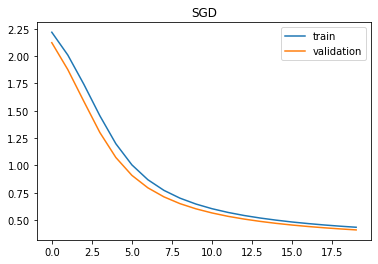

Train accuracy: 0.8870666666666667
Train precision: 0.8858272476688503
Train recall: 0.8852932988861572
Train f1: 0.8852638894457806
Test accuracy: 0.891
Test precision: 0.8893697678504326
Test recall: 0.8891712437161724
Test f1: 0.8888741617166392


In [ ]:
model_sgd=SimpleMLP(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_sgd(model_sgd)
criterion=nn.CrossEntropyLoss().to(device)
model_sgd,_,_=train_optim(trainloader_minibatch,testloader,model_sgd,optimiser,criterion,"SGD",20)



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:33,  6.12it/s]

  1%|          | 9/938 [00:00<00:25, 36.69it/s]

  2%|▏         | 15/938 [00:00<00:20, 44.36it/s]

  2%|▏         | 23/938 [00:00<00:17, 52.15it/s]

  3%|▎         | 29/938 [00:00<00:18, 50.26it/s]

  4%|▍         | 38/938 [00:00<00:14, 60.78it/s]

  5%|▍         | 45/938 [00:00<00:14, 60.59it/s]

  6%|▌         | 52/938 [00:01<00:15, 58.93it/s]

  6%|▋         | 59/938 [00:01<00:14, 60.67it/s]

  7%|▋         | 66/938 [00:01<00:13, 62.43it/s]

  8%|▊         | 73/938 [00:01<00:14, 58.06it/s]

  9%|▊         | 81/938 [00:01<00:13, 61.45it/s]

  9%|▉         | 88/938 [00:01<00:13, 62.19it/s]

 10%|█         | 96/938 [00:01<00:12, 66.17it/s]

 11%|█         | 103/938 [00:01<00:12, 66.65it/s]

 12%|█▏        | 111/938 [00:01<00:12, 68.15it/s]

 13%|█▎        | 118/938 [00:01<00:12, 67.93it/s]

 13%|█▎        | 125/938 [00:02<00:12, 63.68it/s]

 14%|█▍        | 134/938 [00:02<00:11, 68.12it/s]

 15%

Epoch: 1, Train Loss: 1.2842, Test Loss: 0.6047




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:23,  6.54it/s]

  1%|          | 8/938 [00:00<00:25, 36.65it/s]

  1%|▏         | 14/938 [00:00<00:20, 45.84it/s]

  2%|▏         | 21/938 [00:00<00:17, 51.47it/s]

  3%|▎         | 29/938 [00:00<00:16, 56.22it/s]

  4%|▎         | 35/938 [00:00<00:15, 57.04it/s]

  4%|▍         | 42/938 [00:00<00:14, 60.62it/s]

  5%|▌         | 49/938 [00:00<00:15, 58.55it/s]

  6%|▌         | 57/938 [00:01<00:14, 62.02it/s]

  7%|▋         | 65/938 [00:01<00:13, 62.89it/s]

  8%|▊         | 72/938 [00:01<00:13, 62.80it/s]

  8%|▊         | 79/938 [00:01<00:14, 60.64it/s]

  9%|▉         | 87/938 [00:01<00:13, 61.47it/s]

 10%|█         | 95/938 [00:01<00:13, 63.29it/s]

 11%|█         | 104/938 [00:01<00:12, 64.63it/s]

 12%|█▏        | 112/938 [00:01<00:12, 68.07it/s]

 13%|█▎        | 119/938 [00:02<00:12, 66.00it/s]

 13%|█▎        | 126/938 [00:02<00:12, 64.62it/s]

 14%|█▍        | 133/938 [00:02<00:12, 65.33it/s]

 15%

Epoch: 2, Train Loss: 0.5034, Test Loss: 0.4098




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:53, 17.51it/s]

  1%|▏         | 14/938 [00:00<00:12, 72.37it/s]

  3%|▎         | 24/938 [00:00<00:10, 84.31it/s]

  4%|▎         | 35/938 [00:00<00:10, 88.68it/s]

  5%|▍         | 45/938 [00:00<00:09, 92.34it/s]

  6%|▌         | 55/938 [00:00<00:09, 94.79it/s]

  7%|▋         | 66/938 [00:00<00:08, 99.57it/s]

  8%|▊         | 78/938 [00:00<00:08, 101.57it/s]

  9%|▉         | 89/938 [00:00<00:08, 99.63it/s] 

 11%|█         | 100/938 [00:01<00:08, 100.77it/s]

 12%|█▏        | 111/938 [00:01<00:08, 99.59it/s] 

 13%|█▎        | 123/938 [00:01<00:07, 103.71it/s]

 14%|█▍        | 134/938 [00:01<00:07, 101.48it/s]

 16%|█▌        | 146/938 [00:01<00:07, 103.24it/s]

 17%|█▋        | 157/938 [00:01<00:07, 103.49it/s]

 18%|█▊        | 168/938 [00:01<00:08, 89.28it/s] 

 19%|█▉        | 178/938 [00:01<00:09, 81.42it/s]

 20%|█▉        | 187/938 [00:02<00:09, 79.96it/s]

 21%|██        | 196/938 [00:02<00:09, 7

Epoch: 3, Train Loss: 0.3986, Test Loss: 0.3545




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:39,  9.45it/s]

  1%|▏         | 13/938 [00:00<00:12, 72.42it/s]

  2%|▏         | 23/938 [00:00<00:10, 84.79it/s]

  4%|▎         | 33/938 [00:00<00:10, 89.72it/s]

  5%|▍         | 43/938 [00:00<00:09, 93.34it/s]

  6%|▌         | 54/938 [00:00<00:08, 98.45it/s]

  7%|▋         | 64/938 [00:00<00:08, 98.21it/s]

  8%|▊         | 75/938 [00:00<00:08, 101.43it/s]

  9%|▉         | 86/938 [00:00<00:08, 98.30it/s] 

 10%|█         | 96/938 [00:01<00:08, 96.46it/s]

 11%|█▏        | 107/938 [00:01<00:08, 95.73it/s]

 13%|█▎        | 118/938 [00:01<00:08, 97.73it/s]

 14%|█▍        | 130/938 [00:01<00:07, 101.81it/s]

 15%|█▌        | 141/938 [00:01<00:07, 101.58it/s]

 16%|█▌        | 152/938 [00:01<00:07, 99.26it/s] 

 17%|█▋        | 164/938 [00:01<00:07, 103.59it/s]

 19%|█▊        | 175/938 [00:01<00:07, 100.27it/s]

 20%|█▉        | 187/938 [00:01<00:07, 104.74it/s]

 21%|██        | 198/938 [00:02<00:07, 98.

Epoch: 4, Train Loss: 0.3580, Test Loss: 0.3282




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:46,  8.84it/s]

  1%|▏         | 13/938 [00:00<00:13, 68.82it/s]

  2%|▏         | 23/938 [00:00<00:11, 78.17it/s]

  4%|▎         | 35/938 [00:00<00:09, 91.11it/s]

  5%|▍         | 45/938 [00:00<00:09, 93.32it/s]

  6%|▌         | 55/938 [00:00<00:09, 94.24it/s]

  7%|▋         | 67/938 [00:00<00:08, 100.40it/s]

  8%|▊         | 78/938 [00:00<00:08, 98.82it/s] 

  9%|▉         | 88/938 [00:00<00:08, 97.28it/s]

 10%|█         | 98/938 [00:01<00:08, 97.30it/s]

 12%|█▏        | 110/938 [00:01<00:08, 101.63it/s]

 13%|█▎        | 121/938 [00:01<00:08, 100.63it/s]

 14%|█▍        | 132/938 [00:01<00:07, 101.06it/s]

 15%|█▌        | 143/938 [00:01<00:08, 98.89it/s] 

 16%|█▋        | 153/938 [00:01<00:08, 98.06it/s]

 18%|█▊        | 165/938 [00:01<00:07, 103.53it/s]

 19%|█▉        | 176/938 [00:01<00:07, 101.35it/s]

 20%|██        | 188/938 [00:01<00:07, 100.36it/s]

 21%|██        | 199/938 [00:02<00:07, 10

Epoch: 5, Train Loss: 0.3343, Test Loss: 0.3103




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:41,  9.27it/s]

  1%|▏         | 13/938 [00:00<00:13, 66.41it/s]

  2%|▏         | 23/938 [00:00<00:11, 76.84it/s]

  4%|▎         | 35/938 [00:00<00:10, 87.85it/s]

  5%|▍         | 46/938 [00:00<00:09, 95.17it/s]

  6%|▌         | 56/938 [00:00<00:09, 95.87it/s]

  7%|▋         | 67/938 [00:00<00:08, 100.03it/s]

  8%|▊         | 78/938 [00:00<00:08, 98.05it/s] 

  9%|▉         | 88/938 [00:00<00:08, 96.51it/s]

 11%|█         | 99/938 [00:01<00:08, 96.77it/s]

 12%|█▏        | 110/938 [00:01<00:08, 100.37it/s]

 13%|█▎        | 121/938 [00:01<00:08, 97.72it/s] 

 14%|█▍        | 131/938 [00:01<00:08, 96.36it/s]

 15%|█▌        | 142/938 [00:01<00:07, 100.13it/s]

 16%|█▋        | 153/938 [00:01<00:07, 99.82it/s] 

 17%|█▋        | 164/938 [00:01<00:07, 99.79it/s]

 19%|█▊        | 175/938 [00:01<00:07, 98.37it/s]

 20%|█▉        | 186/938 [00:01<00:07, 101.26it/s]

 21%|██        | 197/938 [00:02<00:07, 100.

Epoch: 6, Train Loss: 0.3174, Test Loss: 0.2975




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:38,  9.49it/s]

  1%|▏         | 12/938 [00:00<00:14, 65.00it/s]

  2%|▏         | 22/938 [00:00<00:11, 78.35it/s]

  3%|▎         | 32/938 [00:00<00:10, 86.45it/s]

  4%|▍         | 41/938 [00:00<00:10, 82.47it/s]

  6%|▌         | 52/938 [00:00<00:09, 89.53it/s]

  7%|▋         | 61/938 [00:00<00:09, 89.15it/s]

  7%|▋         | 70/938 [00:00<00:09, 88.66it/s]

  9%|▊         | 80/938 [00:00<00:09, 90.15it/s]

 10%|▉         | 91/938 [00:01<00:09, 93.37it/s]

 11%|█         | 101/938 [00:01<00:08, 93.89it/s]

 12%|█▏        | 111/938 [00:01<00:08, 95.00it/s]

 13%|█▎        | 122/938 [00:01<00:08, 98.52it/s]

 14%|█▍        | 132/938 [00:01<00:08, 96.63it/s]

 15%|█▌        | 142/938 [00:01<00:08, 96.38it/s]

 16%|█▌        | 152/938 [00:01<00:08, 97.18it/s]

 17%|█▋        | 162/938 [00:01<00:07, 97.86it/s]

 18%|█▊        | 172/938 [00:01<00:07, 98.30it/s]

 19%|█▉        | 182/938 [00:01<00:07, 96.31it/s]


Epoch: 7, Train Loss: 0.3037, Test Loss: 0.2858




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:44,  8.96it/s]

  1%|          | 10/938 [00:00<00:17, 53.34it/s]

  2%|▏         | 20/938 [00:00<00:12, 73.22it/s]

  3%|▎         | 29/938 [00:00<00:11, 76.03it/s]

  4%|▍         | 40/938 [00:00<00:10, 86.83it/s]

  5%|▌         | 51/938 [00:00<00:09, 89.91it/s]

  7%|▋         | 61/938 [00:00<00:09, 92.22it/s]

  8%|▊         | 71/938 [00:00<00:09, 94.52it/s]

  9%|▊         | 82/938 [00:00<00:08, 98.17it/s]

 10%|▉         | 92/938 [00:01<00:08, 98.58it/s]

 11%|█         | 102/938 [00:01<00:08, 98.82it/s]

 12%|█▏        | 112/938 [00:01<00:08, 93.85it/s]

 13%|█▎        | 122/938 [00:01<00:08, 94.29it/s]

 14%|█▍        | 132/938 [00:01<00:08, 95.60it/s]

 15%|█▌        | 144/938 [00:01<00:07, 101.76it/s]

 17%|█▋        | 155/938 [00:01<00:08, 93.32it/s] 

 18%|█▊        | 165/938 [00:01<00:08, 93.17it/s]

 19%|█▉        | 176/938 [00:01<00:07, 96.40it/s]

 20%|█▉        | 186/938 [00:02<00:07, 94.81it/s

Epoch: 8, Train Loss: 0.2918, Test Loss: 0.2764




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:37,  5.95it/s]

  1%|          | 8/938 [00:00<00:26, 34.87it/s]

  1%|▏         | 14/938 [00:00<00:20, 44.25it/s]

  2%|▏         | 23/938 [00:00<00:15, 57.85it/s]

  4%|▎         | 33/938 [00:00<00:12, 70.80it/s]

  5%|▍         | 45/938 [00:00<00:10, 83.50it/s]

  6%|▌         | 56/938 [00:00<00:10, 87.22it/s]

  7%|▋         | 66/938 [00:00<00:09, 89.01it/s]

  8%|▊         | 78/938 [00:01<00:09, 93.91it/s]

  9%|▉         | 88/938 [00:01<00:09, 93.54it/s]

 10%|█         | 98/938 [00:01<00:09, 90.14it/s]

 12%|█▏        | 110/938 [00:01<00:08, 94.78it/s]

 13%|█▎        | 121/938 [00:01<00:08, 94.81it/s]

 14%|█▍        | 131/938 [00:01<00:08, 96.18it/s]

 15%|█▌        | 142/938 [00:01<00:08, 96.87it/s]

 16%|█▌        | 152/938 [00:01<00:08, 93.60it/s]

 17%|█▋        | 162/938 [00:01<00:08, 92.33it/s]

 19%|█▊        | 174/938 [00:02<00:07, 95.62it/s]

 20%|█▉        | 184/938 [00:02<00:07, 94.36it/s]

 

Epoch: 9, Train Loss: 0.2815, Test Loss: 0.2669




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:39,  5.88it/s]

  1%|          | 10/938 [00:00<00:21, 43.21it/s]

  2%|▏         | 17/938 [00:00<00:17, 51.51it/s]

  2%|▏         | 23/938 [00:00<00:17, 53.68it/s]

  3%|▎         | 31/938 [00:00<00:15, 58.42it/s]

  4%|▍         | 38/938 [00:00<00:14, 60.29it/s]

  5%|▍         | 45/938 [00:00<00:14, 60.49it/s]

  6%|▌         | 52/938 [00:00<00:14, 60.28it/s]

  6%|▋         | 59/938 [00:01<00:14, 60.40it/s]

  7%|▋         | 66/938 [00:01<00:14, 61.53it/s]

  8%|▊         | 73/938 [00:01<00:13, 62.42it/s]

  9%|▊         | 80/938 [00:01<00:13, 61.99it/s]

  9%|▉         | 87/938 [00:01<00:13, 62.34it/s]

 10%|█         | 94/938 [00:01<00:13, 61.48it/s]

 11%|█         | 101/938 [00:01<00:13, 60.13it/s]

 12%|█▏        | 108/938 [00:01<00:13, 61.70it/s]

 12%|█▏        | 115/938 [00:02<00:14, 55.52it/s]

 13%|█▎        | 123/938 [00:02<00:13, 60.38it/s]

 14%|█▍        | 131/938 [00:02<00:12, 64.95it/s]

 15

Epoch: 10, Train Loss: 0.2720, Test Loss: 0.2600


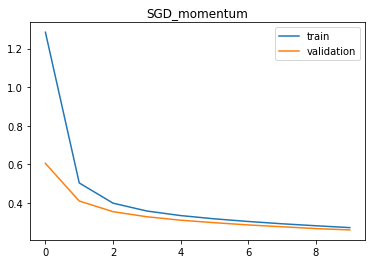

Train accuracy: 0.9251333333333334
Train precision: 0.9244077970848421
Train recall: 0.9241390776869729
Train f1: 0.9241808199850633
Test accuracy: 0.9273
Test precision: 0.9266477062560405
Test recall: 0.9262758769836139
Test f1: 0.9262969144213885


In [ ]:
model_sgd_momentum=SimpleMLP(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_sgd(model_sgd_momentum,momentum=0.9)
criterion=nn.CrossEntropyLoss().to(device)
model_sgd_momentum,_,_=train_optim(trainloader_minibatch,testloader,model_sgd_momentum,optimiser,criterion,"SGD_momentum")



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:37,  9.56it/s]

  1%|▏         | 12/938 [00:00<00:14, 64.47it/s]

  2%|▏         | 22/938 [00:00<00:11, 79.51it/s]

  3%|▎         | 32/938 [00:00<00:10, 86.65it/s]

  4%|▍         | 42/938 [00:00<00:10, 86.17it/s]

  6%|▌         | 52/938 [00:00<00:09, 90.09it/s]

  7%|▋         | 63/938 [00:00<00:09, 94.81it/s]

  8%|▊         | 74/938 [00:00<00:09, 95.35it/s]

  9%|▉         | 86/938 [00:00<00:08, 100.63it/s]

 10%|█         | 97/938 [00:01<00:08, 96.45it/s] 

 11%|█▏        | 107/938 [00:01<00:08, 96.91it/s]

 12%|█▏        | 117/938 [00:01<00:08, 96.07it/s]

 14%|█▎        | 127/938 [00:01<00:08, 96.83it/s]

 15%|█▍        | 137/938 [00:01<00:08, 94.15it/s]

 16%|█▌        | 147/938 [00:01<00:08, 93.59it/s]

 17%|█▋        | 158/938 [00:01<00:08, 95.56it/s]

 18%|█▊        | 169/938 [00:01<00:08, 94.96it/s]

 19%|█▉        | 179/938 [00:01<00:07, 96.14it/s]

 20%|██        | 189/938 [00:02<00:07, 94.87it/s

Epoch: 1, Train Loss: 2.1997, Test Loss: 2.0931




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:54,  8.21it/s]

  1%|▏         | 13/938 [00:00<00:13, 66.79it/s]

  2%|▏         | 21/938 [00:00<00:12, 70.58it/s]

  3%|▎         | 31/938 [00:00<00:11, 76.78it/s]

  4%|▍         | 41/938 [00:00<00:11, 81.14it/s]

  6%|▌         | 53/938 [00:00<00:09, 90.76it/s]

  7%|▋         | 63/938 [00:00<00:09, 93.55it/s]

  8%|▊         | 73/938 [00:00<00:09, 93.25it/s]

  9%|▉         | 85/938 [00:00<00:08, 98.15it/s]

 10%|█         | 96/938 [00:01<00:08, 100.92it/s]

 11%|█▏        | 107/938 [00:01<00:08, 95.67it/s]

 12%|█▏        | 117/938 [00:01<00:08, 96.12it/s]

 14%|█▍        | 129/938 [00:01<00:08, 100.29it/s]

 15%|█▍        | 140/938 [00:01<00:07, 101.76it/s]

 16%|█▌        | 151/938 [00:01<00:07, 102.23it/s]

 17%|█▋        | 162/938 [00:01<00:07, 99.16it/s] 

 18%|█▊        | 172/938 [00:01<00:07, 97.72it/s]

 20%|█▉        | 184/938 [00:01<00:07, 103.55it/s]

 21%|██        | 195/938 [00:02<00:07, 99.83

Epoch: 2, Train Loss: 1.9717, Test Loss: 1.8272




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:51, 18.10it/s]

  1%|▏         | 14/938 [00:00<00:13, 69.22it/s]

  3%|▎         | 24/938 [00:00<00:11, 78.60it/s]

  4%|▍         | 36/938 [00:00<00:09, 90.61it/s]

  5%|▌         | 47/938 [00:00<00:09, 95.98it/s]

  6%|▌         | 57/938 [00:00<00:09, 96.69it/s]

  7%|▋         | 68/938 [00:00<00:08, 98.08it/s]

  8%|▊         | 78/938 [00:00<00:08, 96.49it/s]

  9%|▉         | 89/938 [00:00<00:08, 98.87it/s]

 11%|█         | 100/938 [00:01<00:08, 99.21it/s]

 12%|█▏        | 110/938 [00:01<00:08, 98.20it/s]

 13%|█▎        | 120/938 [00:01<00:08, 98.42it/s]

 14%|█▍        | 130/938 [00:01<00:08, 98.11it/s]

 15%|█▌        | 142/938 [00:01<00:07, 101.63it/s]

 16%|█▋        | 153/938 [00:01<00:07, 102.87it/s]

 17%|█▋        | 164/938 [00:01<00:07, 100.67it/s]

 19%|█▊        | 175/938 [00:01<00:07, 101.12it/s]

 20%|█▉        | 186/938 [00:01<00:07, 96.72it/s] 

 21%|██        | 197/938 [00:02<00:07, 98.40

Epoch: 3, Train Loss: 1.6841, Test Loss: 1.5175




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:47,  8.70it/s]

  1%|▏         | 13/938 [00:00<00:13, 66.41it/s]

  3%|▎         | 24/938 [00:00<00:10, 84.53it/s]

  4%|▎         | 33/938 [00:00<00:10, 85.07it/s]

  5%|▍         | 45/938 [00:00<00:09, 95.10it/s]

  6%|▌         | 55/938 [00:00<00:09, 96.20it/s]

  7%|▋         | 66/938 [00:00<00:09, 94.21it/s]

  8%|▊         | 76/938 [00:00<00:09, 94.51it/s]

  9%|▉         | 86/938 [00:00<00:08, 95.87it/s]

 10%|█         | 97/938 [00:01<00:08, 98.46it/s]

 11%|█▏        | 107/938 [00:01<00:08, 98.45it/s]

 13%|█▎        | 118/938 [00:01<00:08, 100.56it/s]

 14%|█▍        | 129/938 [00:01<00:08, 100.42it/s]

 15%|█▍        | 140/938 [00:01<00:08, 96.70it/s] 

 16%|█▌        | 152/938 [00:01<00:07, 102.62it/s]

 17%|█▋        | 163/938 [00:01<00:07, 98.78it/s] 

 18%|█▊        | 173/938 [00:01<00:07, 97.36it/s]

 20%|█▉        | 184/938 [00:01<00:07, 100.35it/s]

 21%|██        | 195/938 [00:02<00:07, 100.0

Epoch: 4, Train Loss: 1.3862, Test Loss: 1.2337




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:37,  9.66it/s]

  1%|▏         | 14/938 [00:00<00:13, 71.00it/s]

  3%|▎         | 24/938 [00:00<00:11, 80.47it/s]

  4%|▍         | 36/938 [00:00<00:09, 91.02it/s]

  5%|▍         | 46/938 [00:00<00:09, 91.52it/s]

  6%|▌         | 56/938 [00:00<00:09, 88.89it/s]

  7%|▋         | 68/938 [00:00<00:09, 96.08it/s]

  8%|▊         | 78/938 [00:00<00:08, 96.50it/s]

  9%|▉         | 88/938 [00:00<00:08, 95.66it/s]

 10%|█         | 98/938 [00:01<00:08, 95.42it/s]

 12%|█▏        | 108/938 [00:01<00:08, 95.69it/s]

 13%|█▎        | 120/938 [00:01<00:08, 99.14it/s]

 14%|█▍        | 130/938 [00:01<00:08, 99.24it/s]

 15%|█▍        | 140/938 [00:01<00:08, 96.10it/s]

 16%|█▌        | 150/938 [00:01<00:08, 97.07it/s]

 17%|█▋        | 160/938 [00:01<00:08, 92.72it/s]

 18%|█▊        | 170/938 [00:01<00:08, 93.19it/s]

 19%|█▉        | 180/938 [00:01<00:07, 94.91it/s]

 20%|██        | 190/938 [00:02<00:07, 95.87it/s]


Epoch: 5, Train Loss: 1.1387, Test Loss: 1.0197




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:43,  9.01it/s]

  1%|▏         | 12/938 [00:00<00:14, 65.67it/s]

  2%|▏         | 23/938 [00:00<00:11, 82.62it/s]

  3%|▎         | 32/938 [00:00<00:10, 84.39it/s]

  4%|▍         | 41/938 [00:00<00:10, 85.49it/s]

  6%|▌         | 52/938 [00:00<00:09, 90.30it/s]

  7%|▋         | 62/938 [00:00<00:09, 91.67it/s]

  8%|▊         | 74/938 [00:00<00:08, 96.87it/s]

  9%|▉         | 84/938 [00:00<00:09, 88.80it/s]

 10%|█         | 94/938 [00:01<00:09, 91.35it/s]

 11%|█         | 104/938 [00:01<00:09, 92.01it/s]

 12%|█▏        | 115/938 [00:01<00:08, 97.09it/s]

 13%|█▎        | 125/938 [00:01<00:08, 97.72it/s]

 14%|█▍        | 135/938 [00:01<00:08, 95.20it/s]

 16%|█▌        | 146/938 [00:01<00:08, 97.00it/s]

 17%|█▋        | 156/938 [00:01<00:08, 96.87it/s]

 18%|█▊        | 166/938 [00:01<00:07, 96.55it/s]

 19%|█▉        | 176/938 [00:01<00:07, 96.22it/s]

 20%|█▉        | 186/938 [00:02<00:07, 94.34it/s]


Epoch: 6, Train Loss: 0.9598, Test Loss: 0.8701




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:27,  6.34it/s]

  1%|          | 8/938 [00:00<00:26, 35.64it/s]

  1%|▏         | 14/938 [00:00<00:20, 45.13it/s]

  2%|▏         | 21/938 [00:00<00:17, 52.55it/s]

  3%|▎         | 28/938 [00:00<00:16, 54.42it/s]

  4%|▎         | 34/938 [00:00<00:16, 55.31it/s]

  4%|▍         | 41/938 [00:00<00:15, 58.46it/s]

  5%|▌         | 48/938 [00:00<00:15, 59.28it/s]

  6%|▌         | 56/938 [00:01<00:14, 61.99it/s]

  7%|▋         | 63/938 [00:01<00:13, 63.85it/s]

  7%|▋         | 70/938 [00:01<00:14, 60.04it/s]

  9%|▊         | 80/938 [00:01<00:12, 70.58it/s]

 10%|▉         | 91/938 [00:01<00:10, 81.14it/s]

 11%|█         | 102/938 [00:01<00:09, 87.85it/s]

 12%|█▏        | 111/938 [00:01<00:09, 87.67it/s]

 13%|█▎        | 120/938 [00:01<00:09, 87.33it/s]

 14%|█▍        | 130/938 [00:01<00:08, 90.33it/s]

 15%|█▍        | 140/938 [00:01<00:08, 93.01it/s]

 16%|█▌        | 151/938 [00:02<00:08, 96.27it/s]

 17

Epoch: 7, Train Loss: 0.8347, Test Loss: 0.7650




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:11,  7.12it/s]

  1%|          | 8/938 [00:00<00:26, 34.97it/s]

  2%|▏         | 15/938 [00:00<00:18, 48.67it/s]

  2%|▏         | 22/938 [00:00<00:17, 52.29it/s]

  3%|▎         | 28/938 [00:00<00:16, 54.76it/s]

  4%|▎         | 34/938 [00:00<00:16, 55.59it/s]

  5%|▍         | 43/938 [00:00<00:14, 62.35it/s]

  5%|▌         | 50/938 [00:00<00:13, 63.67it/s]

  6%|▌         | 57/938 [00:01<00:13, 63.73it/s]

  7%|▋         | 64/938 [00:01<00:13, 62.75it/s]

  8%|▊         | 71/938 [00:01<00:13, 62.16it/s]

  8%|▊         | 78/938 [00:01<00:14, 59.68it/s]

  9%|▉         | 84/938 [00:01<00:14, 57.42it/s]

 10%|▉         | 92/938 [00:01<00:14, 56.45it/s]

 11%|█         | 101/938 [00:01<00:13, 61.72it/s]

 12%|█▏        | 108/938 [00:01<00:13, 63.73it/s]

 12%|█▏        | 115/938 [00:01<00:13, 63.13it/s]

 13%|█▎        | 122/938 [00:02<00:12, 64.47it/s]

 14%|█▍        | 129/938 [00:02<00:12, 62.80it/s]

 15%

Epoch: 8, Train Loss: 0.7453, Test Loss: 0.6886




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:45,  8.87it/s]

  1%|▏         | 13/938 [00:00<00:13, 69.96it/s]

  2%|▏         | 22/938 [00:00<00:11, 76.72it/s]

  4%|▎         | 34/938 [00:00<00:10, 88.83it/s]

  5%|▍         | 43/938 [00:00<00:11, 75.23it/s]

  5%|▌         | 51/938 [00:00<00:11, 74.59it/s]

  6%|▋         | 59/938 [00:00<00:12, 71.10it/s]

  7%|▋         | 67/938 [00:00<00:11, 73.50it/s]

  8%|▊         | 75/938 [00:01<00:12, 69.23it/s]

  9%|▉         | 83/938 [00:01<00:12, 68.14it/s]

 10%|▉         | 91/938 [00:01<00:12, 67.62it/s]

 11%|█         | 99/938 [00:01<00:12, 65.49it/s]

 11%|█▏        | 107/938 [00:01<00:12, 64.55it/s]

 12%|█▏        | 114/938 [00:01<00:12, 65.87it/s]

 13%|█▎        | 121/938 [00:01<00:12, 63.21it/s]

 14%|█▍        | 129/938 [00:01<00:12, 66.67it/s]

 14%|█▍        | 136/938 [00:01<00:11, 67.48it/s]

 15%|█▌        | 144/938 [00:02<00:12, 66.11it/s]

 16%|█▌        | 152/938 [00:02<00:11, 69.71it/s]

 

Epoch: 9, Train Loss: 0.6792, Test Loss: 0.6312




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:50,  8.45it/s]

  1%|          | 11/938 [00:00<00:16, 57.60it/s]

  2%|▏         | 20/938 [00:00<00:12, 71.64it/s]

  3%|▎         | 29/938 [00:00<00:11, 77.46it/s]

  4%|▍         | 39/938 [00:00<00:10, 83.60it/s]

  5%|▌         | 50/938 [00:00<00:09, 90.61it/s]

  7%|▋         | 61/938 [00:00<00:09, 92.44it/s]

  8%|▊         | 72/938 [00:00<00:09, 95.80it/s]

  9%|▊         | 82/938 [00:00<00:08, 96.39it/s]

 10%|▉         | 92/938 [00:01<00:08, 96.20it/s]

 11%|█         | 103/938 [00:01<00:08, 97.81it/s]

 12%|█▏        | 113/938 [00:01<00:08, 94.83it/s]

 13%|█▎        | 123/938 [00:01<00:08, 90.61it/s]

 14%|█▍        | 133/938 [00:01<00:08, 90.10it/s]

 15%|█▌        | 143/938 [00:01<00:08, 91.28it/s]

 16%|█▋        | 153/938 [00:01<00:08, 92.16it/s]

 17%|█▋        | 163/938 [00:01<00:08, 93.90it/s]

 18%|█▊        | 173/938 [00:01<00:08, 89.36it/s]

 20%|█▉        | 183/938 [00:02<00:08, 84.81it/s]


Epoch: 10, Train Loss: 0.6286, Test Loss: 0.5867


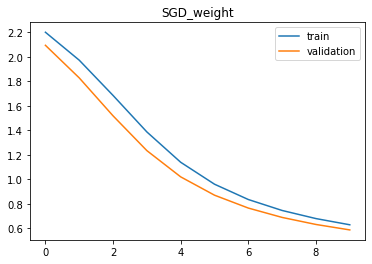

Train accuracy: 0.8584333333333334
Train precision: 0.857460257205578
Train recall: 0.8556648314332881
Train f1: 0.8555403156745982
Test accuracy: 0.8648
Test precision: 0.8636500791605466
Test recall: 0.8620211765100244
Test f1: 0.8615866132502529


In [ ]:
model_sgd_weight=SimpleMLP(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_sgd(model_sgd_weight,weight_decay=1e-4)
criterion=nn.CrossEntropyLoss().to(device)
model_sgd_weight,_,_=train_optim(trainloader_minibatch,testloader,model_sgd_weight,optimiser,criterion,"SGD_weight")



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:45,  8.84it/s]

  1%|▏         | 12/938 [00:00<00:14, 63.89it/s]

  2%|▏         | 21/938 [00:00<00:12, 74.85it/s]

  3%|▎         | 31/938 [00:00<00:11, 80.18it/s]

  4%|▍         | 41/938 [00:00<00:10, 84.54it/s]

  6%|▌         | 52/938 [00:00<00:09, 92.64it/s]

  7%|▋         | 62/938 [00:00<00:09, 93.11it/s]

  8%|▊         | 73/938 [00:00<00:08, 97.53it/s]

  9%|▉         | 83/938 [00:00<00:09, 93.95it/s]

 10%|▉         | 93/938 [00:01<00:08, 93.89it/s]

 11%|█         | 103/938 [00:01<00:08, 93.78it/s]

 12%|█▏        | 113/938 [00:01<00:08, 93.74it/s]

 13%|█▎        | 124/938 [00:01<00:08, 97.63it/s]

 14%|█▍        | 134/938 [00:01<00:08, 90.91it/s]

 15%|█▌        | 144/938 [00:01<00:08, 91.13it/s]

 16%|█▋        | 154/938 [00:01<00:08, 91.61it/s]

 17%|█▋        | 164/938 [00:01<00:08, 92.72it/s]

 19%|█▉        | 176/938 [00:01<00:07, 95.82it/s]

 20%|██        | 188/938 [00:02<00:07, 99.17it/s]


Epoch: 1, Train Loss: 0.3293, Test Loss: 0.2075




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:35,  9.81it/s]

  1%|▏         | 12/938 [00:00<00:14, 64.26it/s]

  2%|▏         | 22/938 [00:00<00:11, 78.55it/s]

  3%|▎         | 32/938 [00:00<00:10, 83.88it/s]

  5%|▍         | 43/938 [00:00<00:10, 86.79it/s]

  6%|▌         | 54/938 [00:00<00:09, 93.86it/s]

  7%|▋         | 64/938 [00:00<00:09, 94.86it/s]

  8%|▊         | 75/938 [00:00<00:09, 95.10it/s]

  9%|▉         | 85/938 [00:00<00:09, 91.47it/s]

 10%|█         | 95/938 [00:01<00:09, 91.53it/s]

 11%|█         | 105/938 [00:01<00:09, 91.97it/s]

 12%|█▏        | 115/938 [00:01<00:09, 89.97it/s]

 14%|█▎        | 127/938 [00:01<00:08, 95.36it/s]

 15%|█▍        | 138/938 [00:01<00:08, 95.02it/s]

 16%|█▌        | 148/938 [00:01<00:08, 94.81it/s]

 17%|█▋        | 159/938 [00:01<00:07, 97.69it/s]

 18%|█▊        | 170/938 [00:01<00:07, 100.84it/s]

 19%|█▉        | 181/938 [00:01<00:07, 97.06it/s] 

 20%|██        | 191/938 [00:02<00:07, 97.51it/s

Epoch: 2, Train Loss: 0.1836, Test Loss: 0.1613




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:43,  9.07it/s]

  1%|          | 11/938 [00:00<00:15, 58.27it/s]

  2%|▏         | 22/938 [00:00<00:12, 75.15it/s]

  3%|▎         | 32/938 [00:00<00:11, 80.05it/s]

  4%|▍         | 42/938 [00:00<00:10, 83.17it/s]

  6%|▌         | 54/938 [00:00<00:09, 91.43it/s]

  7%|▋         | 65/938 [00:00<00:09, 92.46it/s]

  8%|▊         | 75/938 [00:00<00:09, 92.17it/s]

  9%|▉         | 85/938 [00:00<00:09, 94.42it/s]

 10%|█         | 95/938 [00:01<00:09, 93.10it/s]

 11%|█▏        | 107/938 [00:01<00:08, 95.99it/s]

 13%|█▎        | 119/938 [00:01<00:08, 99.89it/s]

 14%|█▍        | 130/938 [00:01<00:08, 97.65it/s]

 15%|█▍        | 140/938 [00:01<00:08, 93.66it/s]

 16%|█▌        | 152/938 [00:01<00:07, 98.30it/s]

 17%|█▋        | 163/938 [00:01<00:07, 98.02it/s]

 19%|█▊        | 174/938 [00:01<00:07, 101.18it/s]

 20%|█▉        | 185/938 [00:02<00:07, 99.62it/s] 

 21%|██        | 195/938 [00:02<00:07, 98.16it/s

Epoch: 3, Train Loss: 0.1348, Test Loss: 0.1296




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:36,  9.74it/s]

  1%|▏         | 12/938 [00:00<00:13, 67.99it/s]

  2%|▏         | 22/938 [00:00<00:11, 79.10it/s]

  4%|▎         | 33/938 [00:00<00:10, 89.89it/s]

  5%|▍         | 43/938 [00:00<00:09, 90.44it/s]

  6%|▌         | 53/938 [00:00<00:09, 92.11it/s]

  7%|▋         | 64/938 [00:00<00:08, 97.59it/s]

  8%|▊         | 74/938 [00:00<00:08, 96.00it/s]

  9%|▉         | 84/938 [00:00<00:09, 93.22it/s]

 10%|█         | 95/938 [00:01<00:08, 94.55it/s]

 11%|█▏        | 106/938 [00:01<00:08, 95.60it/s]

 12%|█▏        | 116/938 [00:01<00:08, 95.59it/s]

 14%|█▎        | 128/938 [00:01<00:08, 99.65it/s]

 15%|█▍        | 138/938 [00:01<00:08, 97.92it/s]

 16%|█▌        | 148/938 [00:01<00:08, 97.40it/s]

 17%|█▋        | 159/938 [00:01<00:07, 100.93it/s]

 18%|█▊        | 170/938 [00:01<00:07, 101.79it/s]

 19%|█▉        | 181/938 [00:01<00:08, 93.94it/s] 

 20%|██        | 191/938 [00:02<00:07, 95.52it/

Epoch: 4, Train Loss: 0.1077, Test Loss: 0.1107




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:34,  6.06it/s]

  1%|          | 8/938 [00:00<00:26, 34.88it/s]

  2%|▏         | 15/938 [00:00<00:19, 47.71it/s]

  2%|▏         | 21/938 [00:00<00:17, 51.53it/s]

  3%|▎         | 28/938 [00:00<00:16, 55.62it/s]

  4%|▎         | 35/938 [00:00<00:17, 52.71it/s]

  5%|▍         | 44/938 [00:00<00:14, 60.10it/s]

  6%|▌         | 52/938 [00:00<00:14, 61.03it/s]

  6%|▋         | 60/938 [00:01<00:13, 64.66it/s]

  7%|▋         | 70/938 [00:01<00:11, 74.20it/s]

  9%|▊         | 80/938 [00:01<00:10, 80.10it/s]

 10%|▉         | 92/938 [00:01<00:09, 89.31it/s]

 11%|█         | 102/938 [00:01<00:09, 90.35it/s]

 12%|█▏        | 112/938 [00:01<00:08, 92.81it/s]

 13%|█▎        | 124/938 [00:01<00:08, 99.40it/s]

 14%|█▍        | 135/938 [00:01<00:08, 94.43it/s]

 15%|█▌        | 145/938 [00:01<00:08, 93.84it/s]

 17%|█▋        | 156/938 [00:02<00:07, 97.99it/s]

 18%|█▊        | 167/938 [00:02<00:07, 97.08it/s]

 1

Epoch: 5, Train Loss: 0.0910, Test Loss: 0.0933




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:40,  5.86it/s]

  1%|          | 9/938 [00:00<00:25, 37.11it/s]

  2%|▏         | 16/938 [00:00<00:19, 46.45it/s]

  2%|▏         | 23/938 [00:00<00:17, 52.94it/s]

  3%|▎         | 30/938 [00:00<00:16, 55.69it/s]

  4%|▍         | 36/938 [00:00<00:16, 56.12it/s]

  5%|▍         | 43/938 [00:00<00:15, 56.59it/s]

  5%|▌         | 49/938 [00:00<00:16, 54.20it/s]

  6%|▌         | 55/938 [00:01<00:15, 55.38it/s]

  7%|▋         | 61/938 [00:01<00:15, 55.49it/s]

  7%|▋         | 67/938 [00:01<00:15, 56.01it/s]

  8%|▊         | 75/938 [00:01<00:14, 61.58it/s]

  9%|▊         | 82/938 [00:01<00:15, 55.90it/s]

  9%|▉         | 88/938 [00:01<00:15, 56.06it/s]

 10%|█         | 94/938 [00:01<00:15, 55.61it/s]

 11%|█         | 101/938 [00:01<00:14, 59.06it/s]

 11%|█▏        | 107/938 [00:01<00:14, 58.84it/s]

 12%|█▏        | 113/938 [00:02<00:14, 57.06it/s]

 13%|█▎        | 120/938 [00:02<00:14, 57.29it/s]

 14%|

Epoch: 6, Train Loss: 0.0776, Test Loss: 0.0968




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:41,  9.21it/s]

  1%|▏         | 12/938 [00:00<00:14, 63.89it/s]

  2%|▏         | 20/938 [00:00<00:12, 70.67it/s]

  3%|▎         | 30/938 [00:00<00:11, 80.62it/s]

  4%|▍         | 39/938 [00:00<00:11, 79.67it/s]

  5%|▌         | 47/938 [00:00<00:11, 74.35it/s]

  6%|▌         | 55/938 [00:00<00:12, 69.29it/s]

  7%|▋         | 63/938 [00:00<00:12, 70.33it/s]

  8%|▊         | 71/938 [00:01<00:13, 65.19it/s]

  8%|▊         | 78/938 [00:01<00:12, 66.32it/s]

  9%|▉         | 85/938 [00:01<00:13, 62.81it/s]

 10%|▉         | 92/938 [00:01<00:13, 64.00it/s]

 11%|█         | 99/938 [00:01<00:13, 60.51it/s]

 12%|█▏        | 108/938 [00:01<00:12, 64.41it/s]

 12%|█▏        | 116/938 [00:01<00:12, 63.99it/s]

 13%|█▎        | 123/938 [00:01<00:12, 63.65it/s]

 14%|█▍        | 130/938 [00:01<00:13, 61.98it/s]

 15%|█▍        | 137/938 [00:02<00:12, 62.34it/s]

 15%|█▌        | 144/938 [00:02<00:12, 62.52it/s]

 1

Epoch: 7, Train Loss: 0.0677, Test Loss: 0.0847




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:55,  8.09it/s]

  1%|          | 11/938 [00:00<00:17, 54.28it/s]

  2%|▏         | 22/938 [00:00<00:12, 72.69it/s]

  3%|▎         | 32/938 [00:00<00:11, 79.03it/s]

  4%|▍         | 42/938 [00:00<00:10, 84.66it/s]

  5%|▌         | 51/938 [00:00<00:11, 80.05it/s]

  7%|▋         | 61/938 [00:00<00:10, 84.43it/s]

  8%|▊         | 71/938 [00:00<00:10, 86.00it/s]

  9%|▊         | 81/938 [00:01<00:09, 87.24it/s]

 10%|▉         | 92/938 [00:01<00:09, 91.17it/s]

 11%|█         | 102/938 [00:01<00:09, 86.78it/s]

 12%|█▏        | 112/938 [00:01<00:09, 90.04it/s]

 13%|█▎        | 123/938 [00:01<00:08, 91.37it/s]

 14%|█▍        | 133/938 [00:01<00:08, 91.12it/s]

 15%|█▌        | 144/938 [00:01<00:08, 96.17it/s]

 16%|█▋        | 154/938 [00:01<00:08, 94.83it/s]

 17%|█▋        | 164/938 [00:01<00:09, 78.27it/s]

 18%|█▊        | 173/938 [00:02<00:10, 74.24it/s]

 19%|█▉        | 181/938 [00:02<00:10, 69.31it/s]


Epoch: 8, Train Loss: 0.0590, Test Loss: 0.0823




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:44,  9.01it/s]

  1%|▏         | 13/938 [00:00<00:13, 67.72it/s]

  3%|▎         | 24/938 [00:00<00:11, 81.80it/s]

  4%|▎         | 33/938 [00:00<00:10, 83.41it/s]

  5%|▍         | 44/938 [00:00<00:10, 88.55it/s]

  6%|▌         | 55/938 [00:00<00:09, 92.57it/s]

  7%|▋         | 65/938 [00:00<00:09, 90.78it/s]

  8%|▊         | 75/938 [00:00<00:09, 92.28it/s]

  9%|▉         | 86/938 [00:00<00:08, 96.74it/s]

 10%|█         | 96/938 [00:01<00:08, 93.68it/s]

 11%|█▏        | 106/938 [00:01<00:08, 94.81it/s]

 12%|█▏        | 117/938 [00:01<00:08, 94.96it/s]

 14%|█▎        | 127/938 [00:01<00:08, 93.14it/s]

 15%|█▍        | 137/938 [00:01<00:08, 94.63it/s]

 16%|█▌        | 149/938 [00:01<00:07, 98.99it/s]

 17%|█▋        | 159/938 [00:01<00:07, 98.74it/s]

 18%|█▊        | 169/938 [00:01<00:07, 97.90it/s]

 19%|█▉        | 179/938 [00:01<00:07, 97.88it/s]

 20%|██        | 189/938 [00:02<00:07, 97.24it/s]


Epoch: 9, Train Loss: 0.0537, Test Loss: 0.0919




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:44,  8.98it/s]

  1%|▏         | 12/938 [00:00<00:14, 63.65it/s]

  2%|▏         | 22/938 [00:00<00:12, 75.33it/s]

  3%|▎         | 32/938 [00:00<00:10, 83.36it/s]

  5%|▍         | 43/938 [00:00<00:09, 89.91it/s]

  6%|▌         | 53/938 [00:00<00:10, 85.29it/s]

  7%|▋         | 65/938 [00:00<00:09, 94.40it/s]

  8%|▊         | 75/938 [00:00<00:09, 92.64it/s]

  9%|▉         | 85/938 [00:01<00:09, 89.76it/s]

 10%|█         | 95/938 [00:01<00:09, 92.52it/s]

 11%|█         | 105/938 [00:01<00:09, 92.38it/s]

 12%|█▏        | 115/938 [00:01<00:08, 92.01it/s]

 13%|█▎        | 126/938 [00:01<00:08, 95.50it/s]

 14%|█▍        | 136/938 [00:01<00:08, 94.91it/s]

 16%|█▌        | 146/938 [00:01<00:08, 94.80it/s]

 17%|█▋        | 156/938 [00:01<00:08, 91.14it/s]

 18%|█▊        | 166/938 [00:01<00:08, 92.19it/s]

 19%|█▉        | 176/938 [00:01<00:08, 93.59it/s]

 20%|█▉        | 186/938 [00:02<00:08, 92.96it/s]


Epoch: 10, Train Loss: 0.0484, Test Loss: 0.0825


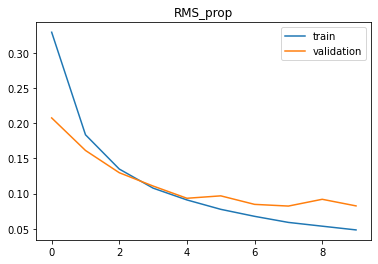

Train accuracy: 0.9886166666666667
Train precision: 0.9886474988586634
Train recall: 0.9885388015561063
Train f1: 0.988568280457212
Test accuracy: 0.9762
Test precision: 0.9763236573172553
Test recall: 0.9759520976016184
Test f1: 0.9760412960831296


In [ ]:
model_rms_prop=SimpleMLP(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_RMSprop(model_rms_prop)
criterion=nn.CrossEntropyLoss().to(device)
model_rms_prop,_,_=train_optim(trainloader_minibatch,testloader,model_rms_prop,optimiser,criterion,"RMS_prop")



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:53,  8.26it/s]

  1%|▏         | 12/938 [00:00<00:15, 61.38it/s]

  2%|▏         | 23/938 [00:00<00:11, 81.82it/s]

  3%|▎         | 32/938 [00:00<00:10, 82.89it/s]

  4%|▍         | 42/938 [00:00<00:10, 86.15it/s]

  6%|▌         | 52/938 [00:00<00:09, 90.17it/s]

  7%|▋         | 62/938 [00:00<00:10, 86.39it/s]

  8%|▊         | 73/938 [00:00<00:09, 91.52it/s]

  9%|▉         | 83/938 [00:00<00:09, 92.64it/s]

 10%|▉         | 93/938 [00:01<00:08, 94.60it/s]

 11%|█         | 103/938 [00:01<00:08, 93.58it/s]

 12%|█▏        | 115/938 [00:01<00:08, 99.54it/s]

 13%|█▎        | 125/938 [00:01<00:08, 96.27it/s]

 14%|█▍        | 136/938 [00:01<00:08, 96.48it/s]

 16%|█▌        | 146/938 [00:01<00:08, 97.45it/s]

 17%|█▋        | 157/938 [00:01<00:08, 96.10it/s]

 18%|█▊        | 167/938 [00:01<00:07, 96.41it/s]

 19%|█▉        | 177/938 [00:01<00:08, 93.27it/s]

 20%|█▉        | 187/938 [00:02<00:07, 94.92it/s]


Epoch: 1, Train Loss: 0.4078, Test Loss: 0.2241




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:47,  8.73it/s]

  1%|          | 11/938 [00:00<00:16, 56.50it/s]

  2%|▏         | 21/938 [00:00<00:12, 72.01it/s]

  3%|▎         | 31/938 [00:00<00:11, 78.71it/s]

  4%|▍         | 41/938 [00:00<00:10, 85.76it/s]

  5%|▌         | 50/938 [00:00<00:10, 86.67it/s]

  7%|▋         | 61/938 [00:00<00:09, 91.60it/s]

  8%|▊         | 71/938 [00:00<00:09, 92.16it/s]

  9%|▊         | 82/938 [00:00<00:09, 92.51it/s]

 10%|▉         | 93/938 [00:01<00:08, 97.52it/s]

 11%|█         | 103/938 [00:01<00:08, 97.42it/s]

 12%|█▏        | 113/938 [00:01<00:08, 94.41it/s]

 13%|█▎        | 123/938 [00:01<00:08, 94.39it/s]

 14%|█▍        | 134/938 [00:01<00:08, 96.05it/s]

 15%|█▌        | 145/938 [00:01<00:08, 95.38it/s]

 17%|█▋        | 155/938 [00:01<00:08, 94.39it/s]

 18%|█▊        | 166/938 [00:01<00:08, 94.47it/s]

 19%|█▉        | 178/938 [00:01<00:07, 98.53it/s]

 20%|██        | 188/938 [00:02<00:07, 97.00it/s]


Epoch: 2, Train Loss: 0.1995, Test Loss: 0.1659




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:52,  8.32it/s]

  1%|          | 10/938 [00:00<00:18, 51.28it/s]

  2%|▏         | 18/938 [00:00<00:14, 62.78it/s]

  3%|▎         | 27/938 [00:00<00:12, 72.26it/s]

  4%|▍         | 36/938 [00:00<00:11, 77.44it/s]

  5%|▍         | 45/938 [00:00<00:11, 78.78it/s]

  6%|▌         | 55/938 [00:00<00:10, 82.97it/s]

  7%|▋         | 65/938 [00:00<00:10, 87.06it/s]

  8%|▊         | 75/938 [00:00<00:09, 89.30it/s]

  9%|▉         | 85/938 [00:01<00:09, 88.39it/s]

 10%|█         | 96/938 [00:01<00:08, 94.17it/s]

 11%|█▏        | 106/938 [00:01<00:09, 92.32it/s]

 12%|█▏        | 116/938 [00:01<00:09, 89.59it/s]

 13%|█▎        | 126/938 [00:01<00:08, 92.09it/s]

 14%|█▍        | 136/938 [00:01<00:08, 91.55it/s]

 16%|█▌        | 146/938 [00:01<00:08, 91.00it/s]

 17%|█▋        | 156/938 [00:01<00:08, 91.36it/s]

 18%|█▊        | 166/938 [00:01<00:08, 93.36it/s]

 19%|█▉        | 176/938 [00:02<00:08, 91.67it/s]



Epoch: 3, Train Loss: 0.1457, Test Loss: 0.1343




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:12,  7.09it/s]

  1%|          | 6/938 [00:00<00:33, 27.74it/s]

  1%|▏         | 12/938 [00:00<00:22, 40.31it/s]

  2%|▏         | 18/938 [00:00<00:20, 44.72it/s]

  3%|▎         | 26/938 [00:00<00:17, 52.53it/s]

  4%|▎         | 34/938 [00:00<00:15, 59.96it/s]

  5%|▍         | 44/938 [00:00<00:12, 70.31it/s]

  6%|▌         | 54/938 [00:00<00:11, 76.85it/s]

  7%|▋         | 64/938 [00:01<00:10, 81.39it/s]

  8%|▊         | 75/938 [00:01<00:09, 87.62it/s]

  9%|▉         | 84/938 [00:01<00:09, 88.17it/s]

 10%|▉         | 93/938 [00:01<00:09, 87.35it/s]

 11%|█         | 103/938 [00:01<00:09, 88.64it/s]

 12%|█▏        | 114/938 [00:01<00:08, 92.77it/s]

 13%|█▎        | 124/938 [00:01<00:08, 92.03it/s]

 14%|█▍        | 136/938 [00:01<00:08, 96.94it/s]

 16%|█▌        | 147/938 [00:01<00:08, 97.37it/s]

 17%|█▋        | 157/938 [00:01<00:08, 96.45it/s]

 18%|█▊        | 167/938 [00:02<00:07, 96.49it/s]

 1

Epoch: 4, Train Loss: 0.1154, Test Loss: 0.1139




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:55,  5.33it/s]

  1%|          | 8/938 [00:00<00:28, 32.29it/s]

  2%|▏         | 16/938 [00:00<00:20, 45.72it/s]

  2%|▏         | 22/938 [00:00<00:18, 49.59it/s]

  3%|▎         | 28/938 [00:00<00:17, 52.87it/s]

  4%|▎         | 34/938 [00:00<00:16, 54.12it/s]

  4%|▍         | 42/938 [00:00<00:15, 57.73it/s]

  5%|▌         | 49/938 [00:00<00:14, 60.75it/s]

  6%|▌         | 56/938 [00:01<00:15, 58.70it/s]

  7%|▋         | 63/938 [00:01<00:15, 58.14it/s]

  8%|▊         | 71/938 [00:01<00:13, 62.70it/s]

  8%|▊         | 78/938 [00:01<00:13, 62.32it/s]

  9%|▉         | 85/938 [00:01<00:13, 62.89it/s]

 10%|▉         | 92/938 [00:01<00:13, 64.54it/s]

 11%|█         | 103/938 [00:01<00:11, 73.57it/s]

 12%|█▏        | 113/938 [00:01<00:10, 79.65it/s]

 13%|█▎        | 124/938 [00:01<00:09, 85.79it/s]

 14%|█▍        | 134/938 [00:02<00:09, 86.43it/s]

 15%|█▌        | 144/938 [00:02<00:08, 88.41it/s]

 16%

Epoch: 5, Train Loss: 0.0951, Test Loss: 0.1049




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:18,  6.75it/s]

  1%|          | 8/938 [00:00<00:25, 35.97it/s]

  1%|▏         | 14/938 [00:00<00:20, 44.34it/s]

  2%|▏         | 21/938 [00:00<00:18, 50.64it/s]

  3%|▎         | 27/938 [00:00<00:17, 51.03it/s]

  4%|▎         | 33/938 [00:00<00:17, 53.21it/s]

  4%|▍         | 40/938 [00:00<00:15, 56.26it/s]

  5%|▍         | 46/938 [00:00<00:15, 56.90it/s]

  6%|▌         | 52/938 [00:01<00:15, 57.42it/s]

  6%|▌         | 58/938 [00:01<00:15, 57.17it/s]

  7%|▋         | 64/938 [00:01<00:15, 56.95it/s]

  8%|▊         | 71/938 [00:01<00:14, 60.55it/s]

  8%|▊         | 78/938 [00:01<00:14, 59.15it/s]

  9%|▉         | 86/938 [00:01<00:13, 63.39it/s]

 10%|▉         | 93/938 [00:01<00:13, 62.46it/s]

 11%|█         | 100/938 [00:01<00:13, 62.00it/s]

 11%|█▏        | 107/938 [00:01<00:13, 60.46it/s]

 12%|█▏        | 114/938 [00:02<00:14, 56.90it/s]

 13%|█▎        | 120/938 [00:02<00:14, 55.86it/s]

 14%|

Epoch: 6, Train Loss: 0.0802, Test Loss: 0.0957




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:46,  8.83it/s]

  1%|          | 11/938 [00:00<00:15, 58.01it/s]

  2%|▏         | 19/938 [00:00<00:13, 66.02it/s]

  3%|▎         | 30/938 [00:00<00:11, 80.46it/s]

  4%|▍         | 39/938 [00:00<00:10, 83.50it/s]

  5%|▌         | 48/938 [00:00<00:11, 77.19it/s]

  6%|▌         | 56/938 [00:00<00:12, 70.18it/s]

  7%|▋         | 64/938 [00:00<00:13, 65.66it/s]

  8%|▊         | 71/938 [00:01<00:13, 66.23it/s]

  8%|▊         | 78/938 [00:01<00:13, 65.20it/s]

  9%|▉         | 85/938 [00:01<00:13, 61.00it/s]

 10%|▉         | 92/938 [00:01<00:13, 61.13it/s]

 11%|█         | 99/938 [00:01<00:14, 59.79it/s]

 11%|█▏        | 107/938 [00:01<00:13, 61.42it/s]

 12%|█▏        | 115/938 [00:01<00:13, 61.64it/s]

 13%|█▎        | 123/938 [00:01<00:12, 65.35it/s]

 14%|█▍        | 130/938 [00:01<00:12, 66.00it/s]

 15%|█▍        | 137/938 [00:02<00:12, 65.66it/s]

 15%|█▌        | 144/938 [00:02<00:12, 63.88it/s]

 1

Epoch: 7, Train Loss: 0.0696, Test Loss: 0.0915




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:41,  9.19it/s]

  1%|▏         | 12/938 [00:00<00:14, 66.04it/s]

  2%|▏         | 21/938 [00:00<00:12, 74.72it/s]

  3%|▎         | 31/938 [00:00<00:10, 82.64it/s]

  4%|▍         | 40/938 [00:00<00:11, 77.96it/s]

  5%|▌         | 50/938 [00:00<00:10, 83.11it/s]

  6%|▋         | 60/938 [00:00<00:10, 85.80it/s]

  8%|▊         | 71/938 [00:00<00:09, 90.15it/s]

  9%|▊         | 81/938 [00:00<00:09, 91.87it/s]

 10%|▉         | 92/938 [00:01<00:09, 92.75it/s]

 11%|█         | 102/938 [00:01<00:09, 91.37it/s]

 12%|█▏        | 112/938 [00:01<00:08, 92.47it/s]

 13%|█▎        | 122/938 [00:01<00:08, 92.93it/s]

 14%|█▍        | 133/938 [00:01<00:08, 94.69it/s]

 15%|█▌        | 143/938 [00:01<00:08, 89.25it/s]

 16%|█▌        | 152/938 [00:01<00:09, 80.92it/s]

 17%|█▋        | 161/938 [00:01<00:09, 78.70it/s]

 18%|█▊        | 169/938 [00:02<00:10, 75.47it/s]

 19%|█▉        | 177/938 [00:02<00:10, 71.81it/s]


Epoch: 8, Train Loss: 0.0609, Test Loss: 0.0878




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:37,  9.59it/s]

  1%|▏         | 12/938 [00:00<00:13, 66.51it/s]

  2%|▏         | 21/938 [00:00<00:12, 72.40it/s]

  3%|▎         | 30/938 [00:00<00:11, 78.53it/s]

  4%|▍         | 41/938 [00:00<00:10, 88.43it/s]

  5%|▌         | 51/938 [00:00<00:10, 88.48it/s]

  7%|▋         | 61/938 [00:00<00:09, 89.94it/s]

  8%|▊         | 71/938 [00:00<00:09, 90.01it/s]

  9%|▊         | 81/938 [00:00<00:09, 88.57it/s]

 10%|▉         | 92/938 [00:01<00:09, 92.72it/s]

 11%|█         | 102/938 [00:01<00:09, 91.73it/s]

 12%|█▏        | 113/938 [00:01<00:08, 95.72it/s]

 13%|█▎        | 123/938 [00:01<00:08, 94.61it/s]

 14%|█▍        | 133/938 [00:01<00:08, 93.64it/s]

 15%|█▌        | 143/938 [00:01<00:08, 93.55it/s]

 16%|█▋        | 153/938 [00:01<00:08, 94.08it/s]

 17%|█▋        | 163/938 [00:01<00:08, 89.82it/s]

 18%|█▊        | 173/938 [00:01<00:08, 86.70it/s]

 20%|█▉        | 183/938 [00:02<00:08, 90.15it/s]


Epoch: 9, Train Loss: 0.0529, Test Loss: 0.0972




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:54,  8.18it/s]

  1%|▏         | 12/938 [00:00<00:15, 58.53it/s]

  2%|▏         | 22/938 [00:00<00:12, 73.09it/s]

  3%|▎         | 32/938 [00:00<00:11, 82.24it/s]

  4%|▍         | 42/938 [00:00<00:10, 85.79it/s]

  6%|▌         | 53/938 [00:00<00:09, 89.63it/s]

  7%|▋         | 64/938 [00:00<00:09, 91.79it/s]

  8%|▊         | 74/938 [00:00<00:09, 92.46it/s]

  9%|▉         | 84/938 [00:01<00:09, 93.71it/s]

 10%|█         | 94/938 [00:01<00:09, 92.29it/s]

 11%|█         | 104/938 [00:01<00:08, 93.72it/s]

 12%|█▏        | 114/938 [00:01<00:08, 92.79it/s]

 13%|█▎        | 124/938 [00:01<00:08, 92.82it/s]

 14%|█▍        | 135/938 [00:01<00:08, 95.23it/s]

 15%|█▌        | 145/938 [00:01<00:08, 93.58it/s]

 17%|█▋        | 156/938 [00:01<00:08, 96.85it/s]

 18%|█▊        | 166/938 [00:01<00:08, 94.39it/s]

 19%|█▉        | 177/938 [00:01<00:07, 95.47it/s]

 20%|█▉        | 187/938 [00:02<00:07, 95.05it/s]


Epoch: 10, Train Loss: 0.0473, Test Loss: 0.0872


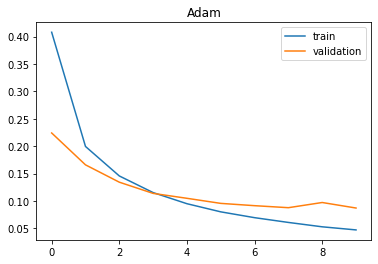

Train accuracy: 0.9902666666666666
Train precision: 0.9901866449190564
Train recall: 0.9902753047051484
Train f1: 0.9902192432942428
Test accuracy: 0.9732
Test precision: 0.9729959046319241
Test recall: 0.9729985702041375
Test f1: 0.9729733372142404


In [ ]:
model_adam=SimpleMLP(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_Adam(model_adam)
criterion=nn.CrossEntropyLoss().to(device)
model_adam,_,_=train_optim(trainloader_minibatch,testloader,model_adam,optimiser,criterion,"Adam")

SGD is a fundamental optimisation algorithm used in MLP training. SGD may experience sluggish convergence and become trapped in local optima. When calculating the current weight update, SGD with momentum considers the direction of the prior update. This decreases oscillations in the weight updates, allowing the optimizer to converge more quickly. Local minima are overridden by the momentum term, which serves as a memory of the direction of the prior update.

As a result, we see that SGD with momentum has superior accuracy than basic SGD. Moreover, due to the momentum factor, SGD with momentum converges at a quicker rate than simple SGD.

A penalty term is added to the loss function in SGD with L2 regularisation, incentivizing the network to use smaller weights. As a result, generalisation effectiveness is enhanced and overfitting is prevented. In contrast to SGD, there is not much of an improvement in test accuracy. This indicates that our model is not much overfitted.

A SGD variant called RMSProp adjusts the learning rate to the strength of the gradients. The root mean square (RMS) of the prior gradients for each weight is divided by the optimizer's learning rate. This quickens convergence and lessens oscillations in the weight updates. As a result, we see that RMSProp's accuracy is substantially higher than SGD's.

Adam is an adaptive learning rate optimization algorithm that combines the advantages of both RMSProp and momentum. It adapts the learning rate for each weight and also takes into account the momentum of the past gradients. Thus, the accuracy for Adam is pretty high.

### Step five: Using SimpleMLP and Adam optimizer, train models using 2 different lr_schedulers.
Select 2 of **MultiplicativeLR**, **MultiStepLR**, **LinearLR** and **ExponentialLR**

Compare the results among different LR schedulers and the original model which didn't employ any LR scheduler. Compile results in a tabular form. Plot losses for each. Explain results.



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:46,  8.79it/s]

  1%|          | 11/938 [00:00<00:15, 59.40it/s]

  2%|▏         | 20/938 [00:00<00:13, 69.96it/s]

  3%|▎         | 32/938 [00:00<00:10, 86.03it/s]

  4%|▍         | 42/938 [00:00<00:10, 89.21it/s]

  6%|▌         | 52/938 [00:00<00:09, 91.36it/s]

  7%|▋         | 63/938 [00:00<00:09, 93.81it/s]

  8%|▊         | 74/938 [00:00<00:08, 97.21it/s]

  9%|▉         | 85/938 [00:00<00:08, 97.44it/s]

 10%|█         | 95/938 [00:01<00:08, 98.14it/s]

 11%|█         | 105/938 [00:01<00:08, 95.98it/s]

 12%|█▏        | 115/938 [00:01<00:08, 95.13it/s]

 13%|█▎        | 125/938 [00:01<00:08, 95.19it/s]

 14%|█▍        | 136/938 [00:01<00:08, 98.90it/s]

 16%|█▌        | 146/938 [00:01<00:08, 97.26it/s]

 17%|█▋        | 157/938 [00:01<00:08, 95.41it/s]

 18%|█▊        | 168/938 [00:01<00:07, 98.99it/s]

 19%|█▉        | 178/938 [00:01<00:07, 99.17it/s]

 20%|██        | 188/938 [00:02<00:07, 97.24it/s]


Epoch: 1, Train Loss: 0.4011, Test Loss: 0.2270




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:43,  9.05it/s]

  1%|          | 10/938 [00:00<00:17, 53.96it/s]

  2%|▏         | 20/938 [00:00<00:12, 71.01it/s]

  3%|▎         | 30/938 [00:00<00:11, 79.92it/s]

  4%|▍         | 40/938 [00:00<00:10, 84.28it/s]

  5%|▌         | 51/938 [00:00<00:10, 87.69it/s]

  7%|▋         | 61/938 [00:00<00:09, 88.06it/s]

  8%|▊         | 72/938 [00:00<00:09, 93.70it/s]

  9%|▊         | 82/938 [00:00<00:09, 92.96it/s]

 10%|▉         | 93/938 [00:01<00:08, 95.87it/s]

 11%|█         | 103/938 [00:01<00:08, 95.18it/s]

 12%|█▏        | 114/938 [00:01<00:08, 97.67it/s]

 13%|█▎        | 124/938 [00:01<00:08, 94.96it/s]

 14%|█▍        | 134/938 [00:01<00:08, 94.10it/s]

 15%|█▌        | 144/938 [00:01<00:08, 95.47it/s]

 17%|█▋        | 155/938 [00:01<00:08, 95.66it/s]

 18%|█▊        | 166/938 [00:01<00:07, 99.48it/s]

 19%|█▉        | 176/938 [00:01<00:07, 96.33it/s]

 20%|█▉        | 186/938 [00:02<00:07, 94.91it/s]


Epoch: 2, Train Loss: 0.2222, Test Loss: 0.2141




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:47,  8.72it/s]

  1%|▏         | 12/938 [00:00<00:14, 63.23it/s]

  2%|▏         | 23/938 [00:00<00:11, 77.64it/s]

  4%|▎         | 34/938 [00:00<00:10, 88.84it/s]

  5%|▍         | 44/938 [00:00<00:09, 92.09it/s]

  6%|▌         | 54/938 [00:00<00:09, 92.80it/s]

  7%|▋         | 65/938 [00:00<00:08, 97.30it/s]

  8%|▊         | 75/938 [00:00<00:08, 97.06it/s]

  9%|▉         | 86/938 [00:00<00:08, 96.27it/s]

 10%|█         | 96/938 [00:01<00:08, 96.70it/s]

 11%|█▏        | 106/938 [00:01<00:08, 94.09it/s]

 13%|█▎        | 118/938 [00:01<00:08, 100.98it/s]

 14%|█▍        | 129/938 [00:01<00:08, 99.27it/s] 

 15%|█▍        | 139/938 [00:01<00:08, 96.49it/s]

 16%|█▌        | 150/938 [00:01<00:08, 96.22it/s]

 17%|█▋        | 160/938 [00:01<00:08, 94.32it/s]

 18%|█▊        | 170/938 [00:01<00:08, 89.76it/s]

 19%|█▉        | 181/938 [00:01<00:08, 94.39it/s]

 20%|██        | 191/938 [00:02<00:07, 94.34it/s

Epoch: 3, Train Loss: 0.2113, Test Loss: 0.2047




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:58,  7.93it/s]

  1%|          | 6/938 [00:00<00:31, 29.21it/s]

  1%|▏         | 13/938 [00:00<00:19, 46.42it/s]

  2%|▏         | 19/938 [00:00<00:18, 50.30it/s]

  3%|▎         | 25/938 [00:00<00:17, 52.31it/s]

  3%|▎         | 31/938 [00:00<00:16, 54.50it/s]

  4%|▍         | 37/938 [00:00<00:16, 55.92it/s]

  5%|▍         | 46/938 [00:00<00:13, 66.11it/s]

  6%|▌         | 57/938 [00:00<00:11, 77.75it/s]

  7%|▋         | 67/938 [00:01<00:10, 82.48it/s]

  8%|▊         | 76/938 [00:01<00:10, 84.12it/s]

  9%|▉         | 86/938 [00:01<00:09, 86.95it/s]

 10%|█         | 96/938 [00:01<00:09, 89.25it/s]

 11%|█         | 105/938 [00:01<00:09, 88.79it/s]

 12%|█▏        | 115/938 [00:01<00:09, 89.67it/s]

 13%|█▎        | 125/938 [00:01<00:08, 91.97it/s]

 15%|█▍        | 137/938 [00:01<00:08, 99.10it/s]

 16%|█▌        | 147/938 [00:01<00:07, 99.22it/s]

 17%|█▋        | 157/938 [00:02<00:07, 97.95it/s]

 18

Epoch: 4, Train Loss: 0.2043, Test Loss: 0.2038




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:17,  6.84it/s]

  1%|          | 7/938 [00:00<00:28, 32.72it/s]

  1%|▏         | 13/938 [00:00<00:21, 43.61it/s]

  2%|▏         | 20/938 [00:00<00:17, 53.23it/s]

  3%|▎         | 26/938 [00:00<00:17, 52.30it/s]

  4%|▎         | 33/938 [00:00<00:15, 57.74it/s]

  4%|▍         | 40/938 [00:00<00:15, 58.45it/s]

  5%|▌         | 48/938 [00:00<00:14, 60.52it/s]

  6%|▌         | 56/938 [00:01<00:14, 61.55it/s]

  7%|▋         | 65/938 [00:01<00:13, 65.72it/s]

  8%|▊         | 72/938 [00:01<00:13, 64.37it/s]

  8%|▊         | 79/938 [00:01<00:14, 61.14it/s]

  9%|▉         | 88/938 [00:01<00:12, 67.25it/s]

 10%|█         | 95/938 [00:01<00:12, 66.36it/s]

 11%|█         | 102/938 [00:01<00:12, 65.59it/s]

 12%|█▏        | 109/938 [00:01<00:12, 64.96it/s]

 12%|█▏        | 116/938 [00:01<00:12, 64.59it/s]

 13%|█▎        | 123/938 [00:02<00:12, 62.99it/s]

 14%|█▍        | 130/938 [00:02<00:13, 61.37it/s]

 15%

Epoch: 5, Train Loss: 0.2032, Test Loss: 0.2030




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:43,  9.08it/s]

  1%|          | 11/938 [00:00<00:15, 59.22it/s]

  2%|▏         | 18/938 [00:00<00:15, 58.70it/s]

  3%|▎         | 26/938 [00:00<00:15, 59.13it/s]

  3%|▎         | 32/938 [00:00<00:15, 58.46it/s]

  4%|▍         | 39/938 [00:00<00:14, 61.43it/s]

  5%|▍         | 46/938 [00:00<00:14, 59.58it/s]

  6%|▌         | 53/938 [00:00<00:14, 62.49it/s]

  6%|▋         | 60/938 [00:01<00:14, 59.49it/s]

  7%|▋         | 67/938 [00:01<00:14, 60.99it/s]

  8%|▊         | 74/938 [00:01<00:13, 62.99it/s]

  9%|▊         | 81/938 [00:01<00:13, 64.66it/s]

  9%|▉         | 88/938 [00:01<00:13, 62.75it/s]

 10%|█         | 95/938 [00:01<00:13, 63.73it/s]

 11%|█         | 103/938 [00:01<00:13, 62.59it/s]

 12%|█▏        | 110/938 [00:01<00:13, 63.54it/s]

 12%|█▏        | 117/938 [00:01<00:13, 62.08it/s]

 13%|█▎        | 124/938 [00:02<00:13, 60.47it/s]

 14%|█▍        | 131/938 [00:02<00:13, 60.10it/s]

 15

Epoch: 6, Train Loss: 0.2024, Test Loss: 0.2029




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:47,  8.70it/s]

  1%|▏         | 12/938 [00:00<00:14, 64.17it/s]

  2%|▏         | 21/938 [00:00<00:12, 74.31it/s]

  3%|▎         | 31/938 [00:00<00:11, 79.71it/s]

  4%|▍         | 41/938 [00:00<00:10, 82.08it/s]

  5%|▌         | 51/938 [00:00<00:10, 84.63it/s]

  7%|▋         | 61/938 [00:00<00:09, 87.96it/s]

  8%|▊         | 71/938 [00:00<00:09, 91.49it/s]

  9%|▊         | 82/938 [00:00<00:09, 93.03it/s]

 10%|▉         | 93/938 [00:01<00:08, 94.75it/s]

 11%|█         | 103/938 [00:01<00:09, 92.25it/s]

 12%|█▏        | 113/938 [00:01<00:08, 93.98it/s]

 13%|█▎        | 124/938 [00:01<00:08, 98.17it/s]

 14%|█▍        | 134/938 [00:01<00:08, 93.42it/s]

 15%|█▌        | 144/938 [00:01<00:09, 81.79it/s]

 16%|█▋        | 153/938 [00:01<00:09, 79.53it/s]

 17%|█▋        | 162/938 [00:01<00:10, 73.32it/s]

 18%|█▊        | 170/938 [00:02<00:11, 66.31it/s]

 19%|█▉        | 178/938 [00:02<00:11, 68.97it/s]


Epoch: 7, Train Loss: 0.2023, Test Loss: 0.2028




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:40,  9.32it/s]

  1%|▏         | 12/938 [00:00<00:15, 60.61it/s]

  2%|▏         | 23/938 [00:00<00:11, 79.67it/s]

  4%|▎         | 33/938 [00:00<00:10, 84.21it/s]

  5%|▍         | 44/938 [00:00<00:09, 92.73it/s]

  6%|▌         | 54/938 [00:00<00:09, 91.17it/s]

  7%|▋         | 64/938 [00:00<00:09, 93.16it/s]

  8%|▊         | 74/938 [00:00<00:09, 92.22it/s]

  9%|▉         | 84/938 [00:00<00:09, 90.37it/s]

 10%|█         | 94/938 [00:01<00:09, 91.62it/s]

 11%|█         | 104/938 [00:01<00:08, 92.87it/s]

 12%|█▏        | 114/938 [00:01<00:08, 93.05it/s]

 13%|█▎        | 125/938 [00:01<00:08, 94.92it/s]

 14%|█▍        | 135/938 [00:01<00:08, 95.88it/s]

 15%|█▌        | 145/938 [00:01<00:08, 94.51it/s]

 17%|█▋        | 155/938 [00:01<00:08, 93.38it/s]

 18%|█▊        | 166/938 [00:01<00:07, 98.06it/s]

 19%|█▉        | 176/938 [00:01<00:08, 93.89it/s]

 20%|█▉        | 186/938 [00:02<00:07, 94.17it/s]


Epoch: 8, Train Loss: 0.2023, Test Loss: 0.2028




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:49,  8.52it/s]

  1%|▏         | 12/938 [00:00<00:15, 60.82it/s]

  2%|▏         | 20/938 [00:00<00:13, 67.18it/s]

  3%|▎         | 31/938 [00:00<00:11, 80.58it/s]

  4%|▍         | 40/938 [00:00<00:10, 83.14it/s]

  5%|▌         | 50/938 [00:00<00:10, 88.20it/s]

  6%|▋         | 60/938 [00:00<00:09, 89.63it/s]

  7%|▋         | 70/938 [00:00<00:09, 92.62it/s]

  9%|▊         | 80/938 [00:00<00:09, 94.54it/s]

 10%|▉         | 90/938 [00:01<00:08, 95.05it/s]

 11%|█         | 101/938 [00:01<00:08, 96.66it/s]

 12%|█▏        | 111/938 [00:01<00:08, 96.36it/s]

 13%|█▎        | 121/938 [00:01<00:08, 92.38it/s]

 14%|█▍        | 131/938 [00:01<00:08, 93.51it/s]

 15%|█▌        | 141/938 [00:01<00:08, 92.03it/s]

 16%|█▌        | 151/938 [00:01<00:08, 92.43it/s]

 17%|█▋        | 161/938 [00:01<00:08, 93.47it/s]

 18%|█▊        | 171/938 [00:01<00:08, 94.63it/s]

 19%|█▉        | 181/938 [00:02<00:08, 94.13it/s]


Epoch: 9, Train Loss: 0.2023, Test Loss: 0.2028




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:40,  9.28it/s]

  1%|          | 11/938 [00:00<00:15, 60.49it/s]

  2%|▏         | 21/938 [00:00<00:12, 74.45it/s]

  3%|▎         | 31/938 [00:00<00:10, 82.56it/s]

  4%|▍         | 42/938 [00:00<00:09, 91.94it/s]

  6%|▌         | 52/938 [00:00<00:09, 91.26it/s]

  7%|▋         | 62/938 [00:00<00:09, 91.23it/s]

  8%|▊         | 72/938 [00:00<00:09, 88.93it/s]

  9%|▊         | 82/938 [00:00<00:09, 91.99it/s]

 10%|▉         | 92/938 [00:01<00:09, 92.92it/s]

 11%|█         | 103/938 [00:01<00:08, 95.94it/s]

 12%|█▏        | 113/938 [00:01<00:08, 95.22it/s]

 13%|█▎        | 123/938 [00:01<00:08, 92.86it/s]

 14%|█▍        | 134/938 [00:01<00:08, 94.06it/s]

 15%|█▌        | 144/938 [00:01<00:08, 95.72it/s]

 16%|█▋        | 154/938 [00:01<00:08, 94.38it/s]

 17%|█▋        | 164/938 [00:01<00:08, 92.99it/s]

 19%|█▊        | 174/938 [00:01<00:08, 90.55it/s]

 20%|█▉        | 185/938 [00:02<00:07, 94.50it/s]


Epoch: 10, Train Loss: 0.2021, Test Loss: 0.2028


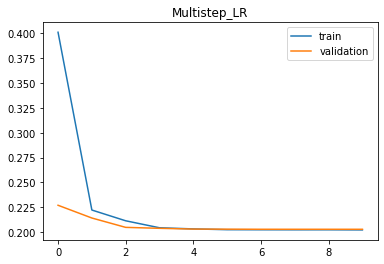

Train accuracy: 0.9431666666666667
Train precision: 0.9426511726860882
Train recall: 0.9424770474056043
Train f1: 0.942530519860348
Test accuracy: 0.9406
Test precision: 0.9398982958599943
Test recall: 0.939826490534012
Test f1: 0.9397785971925166


In [ ]:

model_lr_multistep=SimpleMLP(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_Adam(model_lr_multistep)
scheduler_multistep= optim.lr_scheduler.MultiStepLR(optimiser, milestones=[1,3, 5, 7, 8], gamma=0.1)
criterion=nn.CrossEntropyLoss().to(device)
model_lr_multistep,_,_=train_optim(trainloader_minibatch,testloader,model_lr_multistep,optimiser,criterion,"Multistep_LR",scheduler=scheduler_multistep)



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:00,  7.75it/s]

  1%|▏         | 12/938 [00:00<00:15, 61.23it/s]

  2%|▏         | 21/938 [00:00<00:12, 73.50it/s]

  3%|▎         | 30/938 [00:00<00:11, 78.25it/s]

  4%|▍         | 41/938 [00:00<00:10, 86.03it/s]

  5%|▌         | 50/938 [00:00<00:10, 86.92it/s]

  6%|▋         | 59/938 [00:00<00:10, 85.16it/s]

  7%|▋         | 69/938 [00:00<00:09, 89.09it/s]

  9%|▊         | 80/938 [00:00<00:09, 92.84it/s]

 10%|▉         | 90/938 [00:01<00:09, 90.69it/s]

 11%|█         | 101/938 [00:01<00:08, 94.77it/s]

 12%|█▏        | 111/938 [00:01<00:08, 95.04it/s]

 13%|█▎        | 121/938 [00:01<00:08, 95.90it/s]

 14%|█▍        | 131/938 [00:01<00:08, 95.12it/s]

 15%|█▌        | 141/938 [00:01<00:08, 93.17it/s]

 16%|█▌        | 151/938 [00:01<00:08, 90.07it/s]

 17%|█▋        | 161/938 [00:01<00:08, 92.38it/s]

 18%|█▊        | 171/938 [00:01<00:08, 93.19it/s]

 19%|█▉        | 181/938 [00:02<00:08, 92.86it/s]


Epoch: 1, Train Loss: 0.3999, Test Loss: 0.2348




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:46,  8.78it/s]

  1%|          | 10/938 [00:00<00:17, 53.78it/s]

  2%|▏         | 21/938 [00:00<00:12, 74.86it/s]

  3%|▎         | 31/938 [00:00<00:11, 81.75it/s]

  4%|▍         | 42/938 [00:00<00:10, 87.49it/s]

  6%|▌         | 53/938 [00:00<00:09, 94.20it/s]

  7%|▋         | 63/938 [00:00<00:09, 88.19it/s]

  8%|▊         | 73/938 [00:00<00:09, 89.36it/s]

  9%|▉         | 84/938 [00:01<00:09, 91.92it/s]

 10%|█         | 94/938 [00:01<00:09, 93.65it/s]

 11%|█         | 104/938 [00:01<00:09, 91.63it/s]

 12%|█▏        | 114/938 [00:01<00:08, 93.71it/s]

 13%|█▎        | 124/938 [00:01<00:08, 93.46it/s]

 14%|█▍        | 134/938 [00:01<00:08, 93.57it/s]

 15%|█▌        | 145/938 [00:01<00:08, 95.66it/s]

 17%|█▋        | 155/938 [00:01<00:08, 92.77it/s]

 18%|█▊        | 166/938 [00:01<00:08, 93.30it/s]

 19%|█▉        | 176/938 [00:01<00:08, 94.99it/s]

 20%|█▉        | 186/938 [00:02<00:08, 91.77it/s]


Epoch: 2, Train Loss: 0.2227, Test Loss: 0.2162




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:37,  9.63it/s]

  1%|          | 11/938 [00:00<00:15, 58.01it/s]

  2%|▏         | 21/938 [00:00<00:12, 75.09it/s]

  3%|▎         | 30/938 [00:00<00:11, 79.25it/s]

  4%|▍         | 39/938 [00:00<00:11, 81.65it/s]

  5%|▌         | 49/938 [00:00<00:10, 85.36it/s]

  6%|▌         | 58/938 [00:00<00:10, 83.96it/s]

  7%|▋         | 69/938 [00:00<00:09, 89.94it/s]

  8%|▊         | 79/938 [00:00<00:09, 91.08it/s]

 10%|▉         | 90/938 [00:01<00:09, 92.92it/s]

 11%|█         | 100/938 [00:01<00:08, 93.59it/s]

 12%|█▏        | 111/938 [00:01<00:08, 94.29it/s]

 13%|█▎        | 121/938 [00:01<00:08, 92.68it/s]

 14%|█▍        | 132/938 [00:01<00:08, 96.69it/s]

 15%|█▌        | 142/938 [00:01<00:08, 91.81it/s]

 16%|█▌        | 152/938 [00:01<00:08, 91.94it/s]

 17%|█▋        | 163/938 [00:01<00:08, 93.13it/s]

 18%|█▊        | 173/938 [00:01<00:08, 94.26it/s]

 20%|█▉        | 184/938 [00:02<00:07, 97.84it/s]


Epoch: 3, Train Loss: 0.2141, Test Loss: 0.2145




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:41,  9.20it/s]

  1%|▏         | 12/938 [00:00<00:14, 61.82it/s]

  2%|▏         | 20/938 [00:00<00:13, 68.48it/s]

  3%|▎         | 30/938 [00:00<00:11, 79.15it/s]

  4%|▍         | 39/938 [00:00<00:10, 82.58it/s]

  5%|▌         | 48/938 [00:00<00:10, 83.89it/s]

  6%|▌         | 58/938 [00:00<00:10, 87.57it/s]

  7%|▋         | 67/938 [00:00<00:10, 81.91it/s]

  8%|▊         | 78/938 [00:00<00:09, 88.92it/s]

  9%|▉         | 87/938 [00:01<00:09, 88.55it/s]

 10%|█         | 96/938 [00:01<00:09, 88.05it/s]

 11%|█         | 105/938 [00:01<00:09, 88.22it/s]

 12%|█▏        | 115/938 [00:01<00:09, 90.96it/s]

 13%|█▎        | 125/938 [00:01<00:08, 90.48it/s]

 14%|█▍        | 135/938 [00:01<00:08, 92.43it/s]

 15%|█▌        | 145/938 [00:01<00:08, 92.98it/s]

 17%|█▋        | 155/938 [00:01<00:08, 92.17it/s]

 18%|█▊        | 165/938 [00:01<00:08, 89.89it/s]

 19%|█▊        | 175/938 [00:02<00:08, 91.17it/s]



Epoch: 4, Train Loss: 0.2134, Test Loss: 0.2144




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:32,  6.16it/s]

  1%|          | 8/938 [00:00<00:28, 32.64it/s]

  1%|▏         | 14/938 [00:00<00:22, 40.55it/s]

  3%|▎         | 24/938 [00:00<00:15, 60.48it/s]

  4%|▎         | 33/938 [00:00<00:13, 69.26it/s]

  5%|▍         | 44/938 [00:00<00:11, 80.39it/s]

  6%|▌         | 53/938 [00:00<00:10, 81.25it/s]

  7%|▋         | 62/938 [00:00<00:10, 82.36it/s]

  8%|▊         | 72/938 [00:01<00:10, 83.42it/s]

  9%|▊         | 82/938 [00:01<00:09, 88.10it/s]

 10%|▉         | 93/938 [00:01<00:09, 92.37it/s]

 11%|█         | 103/938 [00:01<00:09, 90.98it/s]

 12%|█▏        | 113/938 [00:01<00:08, 92.26it/s]

 13%|█▎        | 124/938 [00:01<00:08, 95.20it/s]

 14%|█▍        | 134/938 [00:01<00:08, 94.12it/s]

 15%|█▌        | 145/938 [00:01<00:08, 94.59it/s]

 17%|█▋        | 155/938 [00:01<00:08, 93.42it/s]

 18%|█▊        | 165/938 [00:02<00:08, 92.77it/s]

 19%|█▊        | 175/938 [00:02<00:08, 93.95it/s]

 

Epoch: 5, Train Loss: 0.2132, Test Loss: 0.2144




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:30,  6.24it/s]

  1%|          | 6/938 [00:00<00:36, 25.28it/s]

  1%|▏         | 13/938 [00:00<00:22, 41.54it/s]

  2%|▏         | 19/938 [00:00<00:20, 45.89it/s]

  3%|▎         | 27/938 [00:00<00:16, 56.73it/s]

  4%|▎         | 33/938 [00:00<00:15, 56.57it/s]

  4%|▍         | 39/938 [00:00<00:15, 56.44it/s]

  5%|▍         | 45/938 [00:00<00:15, 56.82it/s]

  5%|▌         | 51/938 [00:01<00:15, 56.80it/s]

  6%|▌         | 58/938 [00:01<00:14, 60.13it/s]

  7%|▋         | 67/938 [00:01<00:13, 66.86it/s]

  8%|▊         | 77/938 [00:01<00:11, 74.95it/s]

  9%|▉         | 87/938 [00:01<00:10, 81.42it/s]

 10%|█         | 97/938 [00:01<00:09, 85.42it/s]

 11%|█▏        | 107/938 [00:01<00:09, 89.38it/s]

 12%|█▏        | 117/938 [00:01<00:09, 90.80it/s]

 14%|█▎        | 127/938 [00:01<00:08, 93.01it/s]

 15%|█▍        | 137/938 [00:01<00:08, 93.29it/s]

 16%|█▌        | 147/938 [00:02<00:08, 92.34it/s]

 17%

Epoch: 6, Train Loss: 0.2132, Test Loss: 0.2144




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<03:02,  5.13it/s]

  1%|          | 8/938 [00:00<00:29, 31.98it/s]

  1%|▏         | 14/938 [00:00<00:22, 41.78it/s]

  2%|▏         | 21/938 [00:00<00:18, 49.87it/s]

  3%|▎         | 27/938 [00:00<00:17, 52.25it/s]

  4%|▎         | 33/938 [00:00<00:16, 54.24it/s]

  4%|▍         | 39/938 [00:00<00:16, 55.65it/s]

  5%|▍         | 46/938 [00:00<00:15, 58.82it/s]

  6%|▌         | 52/938 [00:01<00:15, 58.63it/s]

  6%|▌         | 58/938 [00:01<00:14, 58.87it/s]

  7%|▋         | 65/938 [00:01<00:14, 61.52it/s]

  8%|▊         | 72/938 [00:01<00:15, 56.49it/s]

  8%|▊         | 78/938 [00:01<00:15, 53.89it/s]

  9%|▉         | 85/938 [00:01<00:14, 57.97it/s]

 10%|▉         | 92/938 [00:01<00:13, 60.44it/s]

 11%|█         | 99/938 [00:01<00:14, 56.00it/s]

 12%|█▏        | 109/938 [00:01<00:12, 65.89it/s]

 13%|█▎        | 120/938 [00:02<00:10, 75.27it/s]

 14%|█▍        | 130/938 [00:02<00:09, 81.69it/s]

 15%|█

Epoch: 7, Train Loss: 0.2132, Test Loss: 0.2144




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:32,  6.13it/s]

  1%|          | 7/938 [00:00<00:29, 31.20it/s]

  2%|▏         | 15/938 [00:00<00:19, 48.33it/s]

  2%|▏         | 21/938 [00:00<00:18, 50.46it/s]

  3%|▎         | 27/938 [00:00<00:17, 52.91it/s]

  4%|▎         | 33/938 [00:00<00:16, 54.39it/s]

  4%|▍         | 40/938 [00:00<00:15, 58.73it/s]

  5%|▍         | 46/938 [00:00<00:15, 58.82it/s]

  6%|▌         | 53/938 [00:01<00:15, 57.95it/s]

  6%|▋         | 59/938 [00:01<00:15, 55.92it/s]

  7%|▋         | 65/938 [00:01<00:15, 55.84it/s]

  8%|▊         | 73/938 [00:01<00:14, 58.58it/s]

  8%|▊         | 79/938 [00:01<00:14, 58.44it/s]

  9%|▉         | 86/938 [00:01<00:13, 61.57it/s]

 10%|▉         | 93/938 [00:01<00:14, 59.87it/s]

 11%|█         | 100/938 [00:01<00:13, 61.43it/s]

 11%|█▏        | 107/938 [00:01<00:13, 59.68it/s]

 12%|█▏        | 114/938 [00:02<00:13, 61.93it/s]

 13%|█▎        | 121/938 [00:02<00:13, 60.07it/s]

 14%|

Epoch: 8, Train Loss: 0.2133, Test Loss: 0.2144




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:45,  5.67it/s]

  1%|          | 7/938 [00:00<00:31, 29.73it/s]

  1%|▏         | 14/938 [00:00<00:21, 42.11it/s]

  2%|▏         | 21/938 [00:00<00:18, 49.19it/s]

  3%|▎         | 29/938 [00:00<00:16, 54.63it/s]

  4%|▍         | 36/938 [00:00<00:15, 58.63it/s]

  5%|▍         | 43/938 [00:00<00:15, 56.19it/s]

  5%|▌         | 50/938 [00:00<00:15, 56.85it/s]

  6%|▌         | 56/938 [00:01<00:15, 55.75it/s]

  7%|▋         | 64/938 [00:01<00:14, 58.68it/s]

  7%|▋         | 70/938 [00:01<00:14, 58.14it/s]

  8%|▊         | 77/938 [00:01<00:15, 56.06it/s]

  9%|▉         | 87/938 [00:01<00:13, 61.25it/s]

 10%|█         | 95/938 [00:01<00:12, 65.92it/s]

 11%|█         | 102/938 [00:01<00:12, 65.38it/s]

 12%|█▏        | 109/938 [00:01<00:13, 62.41it/s]

 12%|█▏        | 116/938 [00:02<00:14, 56.03it/s]

 13%|█▎        | 123/938 [00:02<00:14, 57.91it/s]

 14%|█▍        | 130/938 [00:02<00:13, 60.25it/s]

 15%

Epoch: 9, Train Loss: 0.2132, Test Loss: 0.2144




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:42,  9.18it/s]

  1%|          | 11/938 [00:00<00:16, 56.58it/s]

  2%|▏         | 21/938 [00:00<00:12, 74.17it/s]

  3%|▎         | 29/938 [00:00<00:13, 65.49it/s]

  4%|▍         | 36/938 [00:00<00:14, 63.94it/s]

  5%|▍         | 44/938 [00:00<00:13, 68.04it/s]

  5%|▌         | 51/938 [00:00<00:13, 67.15it/s]

  6%|▋         | 59/938 [00:00<00:13, 67.18it/s]

  7%|▋         | 66/938 [00:01<00:13, 66.78it/s]

  8%|▊         | 73/938 [00:01<00:14, 61.00it/s]

  9%|▊         | 80/938 [00:01<00:13, 63.23it/s]

  9%|▉         | 87/938 [00:01<00:15, 56.55it/s]

 10%|▉         | 93/938 [00:01<00:15, 56.22it/s]

 11%|█         | 100/938 [00:01<00:14, 59.75it/s]

 11%|█▏        | 107/938 [00:01<00:14, 58.20it/s]

 12%|█▏        | 113/938 [00:01<00:14, 57.91it/s]

 13%|█▎        | 119/938 [00:01<00:14, 58.23it/s]

 13%|█▎        | 126/938 [00:02<00:13, 59.71it/s]

 14%|█▍        | 135/938 [00:02<00:11, 67.23it/s]

 1

Epoch: 10, Train Loss: 0.2132, Test Loss: 0.2144


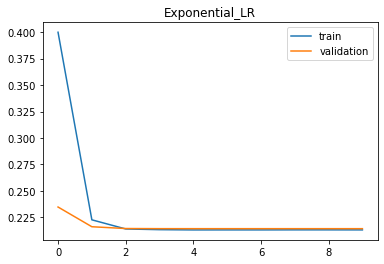

Train accuracy: 0.9401333333333334
Train precision: 0.9396387063034826
Train recall: 0.9395090579827607
Train f1: 0.9395425022825018
Test accuracy: 0.9382
Test precision: 0.9376277488501994
Test recall: 0.9374446541202417
Test f1: 0.9374512055838726


In [ ]:
model_lr_exponential=SimpleMLP(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_Adam(model_lr_exponential)
criterion=nn.CrossEntropyLoss().to(device)
scheduler_exponential = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.1)
model_lr_exponential,_,_=train_optim(trainloader_minibatch,testloader,model_lr_exponential,optimiser,criterion,"Exponential_LR",scheduler=scheduler_exponential)

From the loss curves, we observe that convergence happens faster in the order of time: Adam > Adam with MultistepLR > Adam with ExponentialLR. This is because with MultistepLR, the learning rate is reduced by a certain factor after a fixed number of epochs and with ExponentialLR, the learning rate is reduced exponentially over time. Thus, the convergence happens faster.

### Step six: Define 3 models with following changes:
1. Add BatchNorm
2. Add Dropout
3. Add BatchNorm and Dropout

In [ ]:
class MLP_batchnorm(nn.Module):
    def __init__(self,input_size,h1,out_size):
        super(MLP_batchnorm,self).__init__()
        self.l1=nn.Linear(input_size,h1,device=device)
        self.l2=nn.Linear(h1,h1,device=device)
        self.l3=nn.Linear(h1,out_size,device=device)
        self.b1=nn.BatchNorm1d(h1)
        self.b2=nn.BatchNorm1d(h1)

    def forward(self,x):
        l1=self.l1(x)
        l1=F.relu(self.b1(l1))
        l2=self.l2(l1)
        l2=F.relu(self.b2(l2))
        l3=self.l3(l2)

        return l3

class MLP_dropout(nn.Module):
  def __init__(self,input_size,h1,out,dropout_prob=0.15):
    super(MLP_dropout,self).__init__()
    self.l1=nn.Linear(input_size,h1,device=device)
    self.l2=nn.Linear(h1,h1,device=device)
    self.l3=nn.Linear(h1,out,device=device)
    self.d1=nn.Dropout(p=dropout_prob)
    self.d2=nn.Dropout(p=dropout_prob)
  def forward(self,x):
    l1=F.relu(self.l1(x))
    l1=self.d1(l1)
    l2=F.relu(self.l2(l1))
    l2=self.d2(l2)
    l3=self.l3(l2)

    return l3

class MLP_dropout_batchnorm(nn.Module):
  def __init__(self,input_size,h1,out,dropout_prob=0.15):
    super(MLP_dropout_batchnorm,self).__init__()
    self.l1=nn.Linear(input_size,h1,device=device)
    self.l2=nn.Linear(h1,h1,device=device)
    self.l3=nn.Linear(h1,out,device=device)
    self.d1=nn.Dropout(p=dropout_prob)
    self.d2=nn.Dropout(p=dropout_prob)
    self.b1=nn.BatchNorm1d(h1)
    self.b2=nn.BatchNorm1d(h1)
  
  def forward(self,x): 
      l1=self.l1(x)
      l1=F.relu(self.b1(l1))
      l1=self.d1(l1)
      l2=self.l2(l1)
      l2=F.relu(self.b2(l2))
      l2=self.d2(l2)
      l3=self.l3(l2)
      return l3


In [ ]:
# code here

### Step seven: Train the above models and compare with SimpleMLP.

Use your choice of optimizer, use no lr_scheduler so as to re-use the previous results.

Perform analysis. You've got the drill by now.



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:59,  7.85it/s]

  1%|          | 10/938 [00:00<00:18, 49.96it/s]

  2%|▏         | 18/938 [00:00<00:14, 62.24it/s]

  3%|▎         | 28/938 [00:00<00:12, 72.97it/s]

  4%|▍         | 36/938 [00:00<00:12, 74.74it/s]

  5%|▍         | 46/938 [00:00<00:10, 82.11it/s]

  6%|▌         | 55/938 [00:00<00:10, 81.45it/s]

  7%|▋         | 64/938 [00:00<00:10, 82.06it/s]

  8%|▊         | 73/938 [00:00<00:10, 83.41it/s]

  9%|▊         | 82/938 [00:01<00:10, 84.50it/s]

 10%|▉         | 91/938 [00:01<00:10, 82.07it/s]

 11%|█         | 100/938 [00:01<00:10, 81.85it/s]

 12%|█▏        | 109/938 [00:01<00:09, 83.50it/s]

 13%|█▎        | 118/938 [00:01<00:09, 82.70it/s]

 14%|█▎        | 127/938 [00:01<00:09, 84.20it/s]

 14%|█▍        | 136/938 [00:01<00:09, 85.18it/s]

 15%|█▌        | 145/938 [00:01<00:09, 83.54it/s]

 16%|█▋        | 154/938 [00:01<00:09, 84.93it/s]

 17%|█▋        | 163/938 [00:02<00:09, 83.59it/s]



Epoch: 1, Train Loss: 0.2920, Test Loss: 0.1180




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:50,  8.46it/s]

  1%|          | 10/938 [00:00<00:17, 52.18it/s]

  2%|▏         | 18/938 [00:00<00:14, 63.65it/s]

  3%|▎         | 27/938 [00:00<00:12, 72.24it/s]

  4%|▎         | 35/938 [00:00<00:12, 74.69it/s]

  5%|▍         | 43/938 [00:00<00:12, 72.41it/s]

  6%|▌         | 52/938 [00:00<00:11, 75.68it/s]

  7%|▋         | 61/938 [00:00<00:11, 76.32it/s]

  8%|▊         | 71/938 [00:00<00:10, 80.49it/s]

  9%|▊         | 80/938 [00:01<00:10, 80.56it/s]

  9%|▉         | 89/938 [00:01<00:10, 81.38it/s]

 10%|█         | 98/938 [00:01<00:10, 80.85it/s]

 11%|█▏        | 107/938 [00:01<00:10, 82.31it/s]

 12%|█▏        | 116/938 [00:01<00:09, 82.84it/s]

 13%|█▎        | 125/938 [00:01<00:09, 82.62it/s]

 14%|█▍        | 134/938 [00:01<00:09, 84.40it/s]

 15%|█▌        | 143/938 [00:01<00:09, 84.33it/s]

 16%|█▌        | 152/938 [00:01<00:09, 82.63it/s]

 17%|█▋        | 162/938 [00:02<00:08, 87.51it/s]

 

Epoch: 2, Train Loss: 0.1056, Test Loss: 0.0890




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:50,  8.47it/s]

  1%|          | 10/938 [00:00<00:18, 48.98it/s]

  2%|▏         | 18/938 [00:00<00:14, 61.70it/s]

  3%|▎         | 27/938 [00:00<00:13, 69.52it/s]

  4%|▎         | 35/938 [00:00<00:12, 71.61it/s]

  5%|▍         | 45/938 [00:00<00:11, 77.71it/s]

  6%|▌         | 54/938 [00:00<00:10, 80.95it/s]

  7%|▋         | 63/938 [00:00<00:10, 83.64it/s]

  8%|▊         | 72/938 [00:00<00:10, 84.38it/s]

  9%|▊         | 81/938 [00:01<00:10, 82.15it/s]

 10%|▉         | 91/938 [00:01<00:09, 86.39it/s]

 11%|█         | 100/938 [00:01<00:09, 85.06it/s]

 12%|█▏        | 109/938 [00:01<00:09, 85.40it/s]

 13%|█▎        | 118/938 [00:01<00:09, 83.74it/s]

 14%|█▎        | 128/938 [00:01<00:09, 84.53it/s]

 15%|█▍        | 137/938 [00:01<00:09, 85.43it/s]

 16%|█▌        | 146/938 [00:01<00:09, 84.97it/s]

 17%|█▋        | 155/938 [00:01<00:09, 78.54it/s]

 18%|█▊        | 165/938 [00:02<00:09, 82.40it/s]



Epoch: 3, Train Loss: 0.0737, Test Loss: 0.0855




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:46,  8.77it/s]

  1%|          | 10/938 [00:00<00:18, 51.03it/s]

  2%|▏         | 17/938 [00:00<00:15, 57.75it/s]

  3%|▎         | 27/938 [00:00<00:12, 72.18it/s]

  4%|▎         | 35/938 [00:00<00:12, 72.66it/s]

  5%|▍         | 45/938 [00:00<00:11, 80.77it/s]

  6%|▌         | 54/938 [00:00<00:11, 76.86it/s]

  7%|▋         | 64/938 [00:00<00:10, 82.52it/s]

  8%|▊         | 73/938 [00:00<00:10, 83.16it/s]

  9%|▊         | 82/938 [00:01<00:10, 82.94it/s]

 10%|▉         | 91/938 [00:01<00:10, 84.42it/s]

 11%|█         | 100/938 [00:01<00:10, 83.72it/s]

 12%|█▏        | 109/938 [00:01<00:09, 83.81it/s]

 13%|█▎        | 118/938 [00:01<00:09, 83.58it/s]

 14%|█▍        | 129/938 [00:01<00:09, 87.69it/s]

 15%|█▍        | 138/938 [00:01<00:09, 85.36it/s]

 16%|█▌        | 147/938 [00:01<00:09, 83.50it/s]

 17%|█▋        | 156/938 [00:01<00:09, 82.68it/s]

 18%|█▊        | 166/938 [00:02<00:09, 83.23it/s]



Epoch: 4, Train Loss: 0.0583, Test Loss: 0.0895




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:43,  9.04it/s]

  1%|          | 11/938 [00:00<00:15, 59.44it/s]

  2%|▏         | 20/938 [00:00<00:13, 68.58it/s]

  3%|▎         | 29/938 [00:00<00:12, 71.67it/s]

  4%|▍         | 39/938 [00:00<00:11, 80.54it/s]

  5%|▌         | 48/938 [00:00<00:10, 80.99it/s]

  6%|▌         | 57/938 [00:00<00:10, 83.49it/s]

  7%|▋         | 66/938 [00:00<00:10, 81.93it/s]

  8%|▊         | 75/938 [00:00<00:10, 80.29it/s]

  9%|▉         | 84/938 [00:01<00:10, 81.91it/s]

 10%|█         | 94/938 [00:01<00:10, 82.44it/s]

 11%|█         | 104/938 [00:01<00:09, 85.05it/s]

 12%|█▏        | 113/938 [00:01<00:09, 82.65it/s]

 13%|█▎        | 122/938 [00:01<00:09, 83.34it/s]

 14%|█▍        | 131/938 [00:01<00:09, 84.98it/s]

 15%|█▍        | 140/938 [00:01<00:09, 84.76it/s]

 16%|█▌        | 149/938 [00:01<00:09, 85.04it/s]

 17%|█▋        | 158/938 [00:01<00:09, 86.07it/s]

 18%|█▊        | 167/938 [00:02<00:09, 81.38it/s]



Epoch: 5, Train Loss: 0.0512, Test Loss: 0.0817




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:01,  7.68it/s]

  1%|          | 10/938 [00:00<00:18, 49.78it/s]

  2%|▏         | 18/938 [00:00<00:14, 61.70it/s]

  3%|▎         | 27/938 [00:00<00:12, 71.45it/s]

  4%|▍         | 36/938 [00:00<00:11, 75.76it/s]

  5%|▍         | 45/938 [00:00<00:11, 79.88it/s]

  6%|▌         | 54/938 [00:00<00:10, 80.83it/s]

  7%|▋         | 63/938 [00:00<00:10, 81.85it/s]

  8%|▊         | 72/938 [00:00<00:10, 81.62it/s]

  9%|▊         | 81/938 [00:01<00:10, 78.82it/s]

 10%|▉         | 90/938 [00:01<00:10, 81.41it/s]

 11%|█         | 99/938 [00:01<00:10, 80.19it/s]

 12%|█▏        | 108/938 [00:01<00:10, 80.47it/s]

 12%|█▏        | 117/938 [00:01<00:10, 82.05it/s]

 13%|█▎        | 126/938 [00:01<00:09, 83.85it/s]

 14%|█▍        | 135/938 [00:01<00:09, 82.65it/s]

 15%|█▌        | 144/938 [00:01<00:09, 82.68it/s]

 16%|█▋        | 153/938 [00:01<00:09, 84.14it/s]

 17%|█▋        | 163/938 [00:02<00:08, 86.47it/s]

 

Epoch: 6, Train Loss: 0.0392, Test Loss: 0.0820




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:52,  8.30it/s]

  1%|          | 10/938 [00:00<00:19, 48.45it/s]

  2%|▏         | 19/938 [00:00<00:14, 65.10it/s]

  3%|▎         | 28/938 [00:00<00:12, 71.05it/s]

  4%|▍         | 37/938 [00:00<00:11, 77.11it/s]

  5%|▍         | 45/938 [00:00<00:11, 77.41it/s]

  6%|▌         | 54/938 [00:00<00:11, 80.20it/s]

  7%|▋         | 64/938 [00:00<00:10, 83.84it/s]

  8%|▊         | 73/938 [00:00<00:10, 81.22it/s]

  9%|▊         | 82/938 [00:01<00:10, 82.16it/s]

 10%|▉         | 91/938 [00:01<00:10, 81.31it/s]

 11%|█         | 100/938 [00:01<00:10, 78.64it/s]

 12%|█▏        | 110/938 [00:01<00:10, 82.52it/s]

 13%|█▎        | 120/938 [00:01<00:09, 85.37it/s]

 14%|█▍        | 129/938 [00:01<00:09, 83.35it/s]

 15%|█▍        | 138/938 [00:01<00:09, 83.20it/s]

 16%|█▌        | 147/938 [00:01<00:09, 81.04it/s]

 17%|█▋        | 156/938 [00:02<00:10, 77.37it/s]

 17%|█▋        | 164/938 [00:02<00:10, 75.98it/s]



Epoch: 7, Train Loss: 0.0341, Test Loss: 0.0930




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:49,  8.54it/s]

  1%|          | 10/938 [00:00<00:17, 53.08it/s]

  2%|▏         | 18/938 [00:00<00:14, 64.61it/s]

  3%|▎         | 28/938 [00:00<00:12, 74.19it/s]

  4%|▍         | 38/938 [00:00<00:11, 80.96it/s]

  5%|▌         | 47/938 [00:00<00:11, 80.36it/s]

  6%|▌         | 57/938 [00:00<00:10, 84.93it/s]

  7%|▋         | 66/938 [00:00<00:10, 84.74it/s]

  8%|▊         | 75/938 [00:00<00:10, 82.10it/s]

  9%|▉         | 84/938 [00:01<00:10, 83.51it/s]

 10%|▉         | 93/938 [00:01<00:10, 80.19it/s]

 11%|█         | 102/938 [00:01<00:10, 79.52it/s]

 12%|█▏        | 112/938 [00:01<00:09, 84.40it/s]

 13%|█▎        | 121/938 [00:01<00:09, 84.19it/s]

 14%|█▍        | 130/938 [00:01<00:09, 84.97it/s]

 15%|█▍        | 139/938 [00:01<00:09, 85.78it/s]

 16%|█▌        | 148/938 [00:01<00:09, 85.37it/s]

 17%|█▋        | 157/938 [00:01<00:09, 84.40it/s]

 18%|█▊        | 166/938 [00:02<00:09, 81.73it/s]



Epoch: 8, Train Loss: 0.0325, Test Loss: 0.0891




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:02,  7.65it/s]

  1%|          | 11/938 [00:00<00:17, 53.64it/s]

  2%|▏         | 20/938 [00:00<00:14, 63.10it/s]

  3%|▎         | 28/938 [00:00<00:13, 67.89it/s]

  4%|▍         | 37/938 [00:00<00:12, 74.54it/s]

  5%|▍         | 46/938 [00:00<00:11, 78.26it/s]

  6%|▌         | 55/938 [00:00<00:11, 78.44it/s]

  7%|▋         | 65/938 [00:00<00:10, 83.37it/s]

  8%|▊         | 74/938 [00:01<00:10, 81.25it/s]

  9%|▉         | 83/938 [00:01<00:10, 79.67it/s]

 10%|▉         | 92/938 [00:01<00:10, 82.25it/s]

 11%|█         | 101/938 [00:01<00:10, 82.02it/s]

 12%|█▏        | 110/938 [00:01<00:10, 82.48it/s]

 13%|█▎        | 119/938 [00:01<00:09, 83.77it/s]

 14%|█▎        | 128/938 [00:01<00:09, 82.61it/s]

 15%|█▍        | 138/938 [00:01<00:09, 85.01it/s]

 16%|█▌        | 147/938 [00:01<00:09, 86.39it/s]

 17%|█▋        | 156/938 [00:01<00:09, 84.36it/s]

 18%|█▊        | 165/938 [00:02<00:09, 84.33it/s]



Epoch: 9, Train Loss: 0.0269, Test Loss: 0.0938




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:52,  8.31it/s]

  1%|          | 11/938 [00:00<00:16, 55.33it/s]

  2%|▏         | 19/938 [00:00<00:14, 63.41it/s]

  3%|▎         | 27/938 [00:00<00:13, 69.22it/s]

  4%|▍         | 37/938 [00:00<00:11, 77.55it/s]

  5%|▍         | 46/938 [00:00<00:11, 79.73it/s]

  6%|▌         | 55/938 [00:00<00:10, 82.92it/s]

  7%|▋         | 64/938 [00:00<00:10, 80.08it/s]

  8%|▊         | 73/938 [00:00<00:10, 82.30it/s]

  9%|▊         | 82/938 [00:01<00:10, 80.48it/s]

 10%|▉         | 91/938 [00:01<00:10, 79.43it/s]

 11%|█         | 100/938 [00:01<00:10, 79.55it/s]

 12%|█▏        | 108/938 [00:01<00:10, 78.20it/s]

 12%|█▏        | 116/938 [00:01<00:10, 78.65it/s]

 13%|█▎        | 126/938 [00:01<00:09, 83.78it/s]

 14%|█▍        | 135/938 [00:01<00:09, 83.76it/s]

 15%|█▌        | 144/938 [00:01<00:09, 83.65it/s]

 16%|█▋        | 153/938 [00:01<00:09, 83.83it/s]

 17%|█▋        | 162/938 [00:02<00:09, 85.51it/s]



Epoch: 10, Train Loss: 0.0247, Test Loss: 0.0969


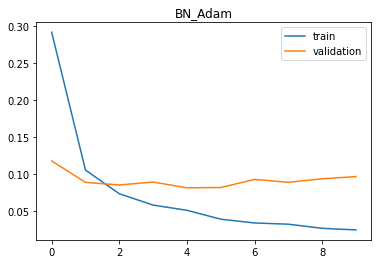

Train accuracy: 0.9929666666666667
Train precision: 0.9929779469820208
Train recall: 0.9928675366653799
Train f1: 0.9928921793762792
Test accuracy: 0.9752
Test precision: 0.9754701020441734
Test recall: 0.9748148807527924
Test f1: 0.975043533188073


In [ ]:
model_bn_adam=MLP_batchnorm(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_Adam(model_bn_adam)
criterion=nn.CrossEntropyLoss().to(device)
model_bn_adam,_,_=train_optim(trainloader_minibatch,testloader,model_bn_adam,optimiser,criterion,"BN_Adam")



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:47,  8.72it/s]

  1%|          | 11/938 [00:00<00:16, 56.34it/s]

  2%|▏         | 19/938 [00:00<00:13, 66.45it/s]

  3%|▎         | 29/938 [00:00<00:12, 73.74it/s]

  4%|▍         | 39/938 [00:00<00:11, 81.10it/s]

  5%|▌         | 48/938 [00:00<00:10, 81.86it/s]

  6%|▋         | 59/938 [00:00<00:10, 86.10it/s]

  7%|▋         | 69/938 [00:00<00:09, 87.68it/s]

  8%|▊         | 78/938 [00:01<00:10, 83.34it/s]

  9%|▉         | 88/938 [00:01<00:09, 87.95it/s]

 10%|█         | 97/938 [00:01<00:09, 84.98it/s]

 12%|█▏        | 108/938 [00:01<00:09, 87.70it/s]

 13%|█▎        | 119/938 [00:01<00:08, 91.11it/s]

 14%|█▍        | 129/938 [00:01<00:09, 87.53it/s]

 15%|█▍        | 138/938 [00:01<00:09, 86.42it/s]

 16%|█▌        | 147/938 [00:01<00:09, 87.17it/s]

 17%|█▋        | 156/938 [00:01<00:09, 85.19it/s]

 18%|█▊        | 166/938 [00:02<00:09, 84.76it/s]

 19%|█▉        | 176/938 [00:02<00:08, 87.98it/s]



Epoch: 1, Train Loss: 0.4654, Test Loss: 0.1961




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:51,  8.38it/s]

  1%|          | 10/938 [00:00<00:17, 51.95it/s]

  2%|▏         | 20/938 [00:00<00:13, 67.37it/s]

  3%|▎         | 30/938 [00:00<00:11, 75.85it/s]

  4%|▍         | 40/938 [00:00<00:11, 81.20it/s]

  5%|▌         | 50/938 [00:00<00:10, 84.61it/s]

  6%|▋         | 59/938 [00:00<00:10, 86.24it/s]

  7%|▋         | 68/938 [00:00<00:10, 84.84it/s]

  8%|▊         | 79/938 [00:00<00:09, 89.61it/s]

  9%|▉         | 88/938 [00:01<00:10, 84.75it/s]

 11%|█         | 99/938 [00:01<00:09, 90.83it/s]

 12%|█▏        | 109/938 [00:01<00:09, 90.27it/s]

 13%|█▎        | 119/938 [00:01<00:09, 90.71it/s]

 14%|█▍        | 129/938 [00:01<00:08, 91.22it/s]

 15%|█▍        | 139/938 [00:01<00:08, 92.59it/s]

 16%|█▌        | 149/938 [00:01<00:08, 94.60it/s]

 17%|█▋        | 159/938 [00:01<00:08, 93.87it/s]

 18%|█▊        | 169/938 [00:01<00:08, 89.94it/s]

 19%|█▉        | 180/938 [00:02<00:08, 93.28it/s]



Epoch: 2, Train Loss: 0.1601, Test Loss: 0.1322




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:51,  8.40it/s]

  1%|          | 11/938 [00:00<00:16, 54.71it/s]

  2%|▏         | 19/938 [00:00<00:14, 64.71it/s]

  3%|▎         | 29/938 [00:00<00:11, 77.23it/s]

  4%|▍         | 38/938 [00:00<00:11, 78.99it/s]

  5%|▌         | 47/938 [00:00<00:11, 80.24it/s]

  6%|▌         | 58/938 [00:00<00:10, 85.28it/s]

  7%|▋         | 67/938 [00:00<00:10, 86.40it/s]

  8%|▊         | 77/938 [00:00<00:09, 87.31it/s]

  9%|▉         | 86/938 [00:01<00:10, 83.95it/s]

 10%|█         | 97/938 [00:01<00:09, 88.29it/s]

 11%|█▏        | 106/938 [00:01<00:09, 86.86it/s]

 12%|█▏        | 117/938 [00:01<00:09, 90.81it/s]

 14%|█▎        | 127/938 [00:01<00:08, 90.18it/s]

 15%|█▍        | 137/938 [00:01<00:08, 91.27it/s]

 16%|█▌        | 147/938 [00:01<00:08, 91.08it/s]

 17%|█▋        | 157/938 [00:01<00:08, 91.34it/s]

 18%|█▊        | 167/938 [00:01<00:08, 91.49it/s]

 19%|█▉        | 177/938 [00:02<00:08, 88.22it/s]



Epoch: 3, Train Loss: 0.1095, Test Loss: 0.1088




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:44,  8.97it/s]

  1%|▏         | 12/938 [00:00<00:15, 61.45it/s]

  2%|▏         | 20/938 [00:00<00:13, 68.20it/s]

  3%|▎         | 31/938 [00:00<00:11, 80.59it/s]

  4%|▍         | 41/938 [00:00<00:10, 82.58it/s]

  6%|▌         | 52/938 [00:00<00:09, 89.28it/s]

  7%|▋         | 61/938 [00:00<00:10, 86.77it/s]

  7%|▋         | 70/938 [00:00<00:09, 87.56it/s]

  8%|▊         | 79/938 [00:00<00:10, 84.73it/s]

  9%|▉         | 88/938 [00:01<00:09, 85.35it/s]

 10%|█         | 98/938 [00:01<00:09, 86.29it/s]

 11%|█▏        | 107/938 [00:01<00:09, 87.19it/s]

 12%|█▏        | 116/938 [00:01<00:09, 87.34it/s]

 13%|█▎        | 125/938 [00:01<00:09, 87.77it/s]

 14%|█▍        | 135/938 [00:01<00:09, 87.55it/s]

 16%|█▌        | 146/938 [00:01<00:08, 89.09it/s]

 17%|█▋        | 156/938 [00:01<00:08, 89.72it/s]

 18%|█▊        | 165/938 [00:01<00:08, 87.37it/s]

 19%|█▊        | 174/938 [00:02<00:08, 85.34it/s]



Epoch: 4, Train Loss: 0.0845, Test Loss: 0.1007




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:40,  9.29it/s]

  1%|          | 11/938 [00:00<00:15, 58.20it/s]

  2%|▏         | 21/938 [00:00<00:12, 74.80it/s]

  3%|▎         | 30/938 [00:00<00:11, 80.19it/s]

  4%|▍         | 40/938 [00:00<00:10, 84.53it/s]

  5%|▌         | 49/938 [00:00<00:10, 84.81it/s]

  6%|▌         | 58/938 [00:00<00:10, 84.90it/s]

  7%|▋         | 67/938 [00:00<00:10, 84.77it/s]

  8%|▊         | 76/938 [00:00<00:10, 83.82it/s]

  9%|▉         | 86/938 [00:01<00:09, 87.77it/s]

 10%|█         | 95/938 [00:01<00:09, 85.71it/s]

 11%|█         | 105/938 [00:01<00:09, 87.74it/s]

 12%|█▏        | 114/938 [00:01<00:09, 84.02it/s]

 13%|█▎        | 124/938 [00:01<00:09, 85.10it/s]

 14%|█▍        | 134/938 [00:01<00:09, 86.14it/s]

 15%|█▌        | 144/938 [00:01<00:09, 87.55it/s]

 16%|█▋        | 153/938 [00:01<00:09, 85.38it/s]

 17%|█▋        | 162/938 [00:01<00:09, 85.58it/s]

 18%|█▊        | 172/938 [00:02<00:08, 88.60it/s]



Epoch: 5, Train Loss: 0.0670, Test Loss: 0.0966




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:41,  9.24it/s]

  1%|          | 10/938 [00:00<00:17, 53.97it/s]

  2%|▏         | 20/938 [00:00<00:13, 69.76it/s]

  3%|▎         | 28/938 [00:00<00:12, 72.75it/s]

  4%|▍         | 38/938 [00:00<00:11, 78.72it/s]

  5%|▌         | 48/938 [00:00<00:10, 82.75it/s]

  6%|▌         | 57/938 [00:00<00:10, 83.47it/s]

  7%|▋         | 68/938 [00:00<00:09, 88.22it/s]

  8%|▊         | 79/938 [00:00<00:09, 90.72it/s]

  9%|▉         | 89/938 [00:01<00:09, 92.71it/s]

 11%|█         | 99/938 [00:01<00:09, 90.69it/s]

 12%|█▏        | 109/938 [00:01<00:09, 91.65it/s]

 13%|█▎        | 119/938 [00:01<00:08, 93.49it/s]

 14%|█▍        | 129/938 [00:01<00:09, 88.43it/s]

 15%|█▍        | 140/938 [00:01<00:08, 91.66it/s]

 16%|█▌        | 150/938 [00:01<00:08, 88.34it/s]

 17%|█▋        | 160/938 [00:01<00:08, 88.63it/s]

 18%|█▊        | 170/938 [00:01<00:08, 90.19it/s]

 19%|█▉        | 180/938 [00:02<00:08, 89.13it/s]



Epoch: 6, Train Loss: 0.0552, Test Loss: 0.0927




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:42,  9.14it/s]

  1%|          | 10/938 [00:00<00:17, 54.43it/s]

  2%|▏         | 18/938 [00:00<00:14, 62.02it/s]

  3%|▎         | 26/938 [00:00<00:13, 68.14it/s]

  4%|▍         | 36/938 [00:00<00:11, 76.20it/s]

  5%|▍         | 46/938 [00:00<00:10, 83.03it/s]

  6%|▌         | 55/938 [00:00<00:10, 83.50it/s]

  7%|▋         | 64/938 [00:00<00:10, 84.65it/s]

  8%|▊         | 74/938 [00:00<00:09, 89.17it/s]

  9%|▉         | 83/938 [00:01<00:09, 87.12it/s]

 10%|▉         | 93/938 [00:01<00:09, 89.79it/s]

 11%|█         | 102/938 [00:01<00:09, 86.67it/s]

 12%|█▏        | 112/938 [00:01<00:09, 88.47it/s]

 13%|█▎        | 122/938 [00:01<00:09, 88.63it/s]

 14%|█▍        | 132/938 [00:01<00:09, 89.31it/s]

 15%|█▌        | 143/938 [00:01<00:08, 93.66it/s]

 16%|█▋        | 153/938 [00:01<00:08, 93.25it/s]

 17%|█▋        | 163/938 [00:01<00:08, 92.53it/s]

 18%|█▊        | 173/938 [00:02<00:08, 89.43it/s]



Epoch: 7, Train Loss: 0.0460, Test Loss: 0.0920




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:49,  8.57it/s]

  1%|          | 10/938 [00:00<00:17, 53.37it/s]

  2%|▏         | 19/938 [00:00<00:13, 66.73it/s]

  3%|▎         | 27/938 [00:00<00:12, 71.50it/s]

  4%|▍         | 37/938 [00:00<00:11, 79.98it/s]

  5%|▍         | 46/938 [00:00<00:11, 80.82it/s]

  6%|▌         | 56/938 [00:00<00:10, 86.69it/s]

  7%|▋         | 65/938 [00:00<00:10, 85.54it/s]

  8%|▊         | 74/938 [00:00<00:10, 86.34it/s]

  9%|▉         | 84/938 [00:01<00:09, 88.87it/s]

 10%|▉         | 93/938 [00:01<00:09, 86.83it/s]

 11%|█         | 102/938 [00:01<00:09, 86.99it/s]

 12%|█▏        | 111/938 [00:01<00:09, 87.48it/s]

 13%|█▎        | 120/938 [00:01<00:09, 87.51it/s]

 14%|█▍        | 129/938 [00:01<00:09, 86.41it/s]

 15%|█▍        | 139/938 [00:01<00:08, 89.38it/s]

 16%|█▌        | 148/938 [00:01<00:09, 87.61it/s]

 17%|█▋        | 159/938 [00:01<00:08, 89.58it/s]

 18%|█▊        | 169/938 [00:02<00:08, 91.53it/s]



Epoch: 8, Train Loss: 0.0385, Test Loss: 0.0838




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:44,  8.95it/s]

  1%|          | 10/938 [00:00<00:17, 54.09it/s]

  2%|▏         | 19/938 [00:00<00:13, 68.37it/s]

  3%|▎         | 28/938 [00:00<00:12, 73.87it/s]

  4%|▍         | 39/938 [00:00<00:10, 82.98it/s]

  5%|▌         | 48/938 [00:00<00:10, 83.88it/s]

  6%|▌         | 57/938 [00:00<00:10, 80.80it/s]

  7%|▋         | 67/938 [00:00<00:10, 84.36it/s]

  8%|▊         | 76/938 [00:00<00:10, 85.47it/s]

  9%|▉         | 86/938 [00:01<00:09, 87.82it/s]

 10%|█         | 95/938 [00:01<00:09, 86.08it/s]

 11%|█▏        | 106/938 [00:01<00:09, 90.11it/s]

 12%|█▏        | 116/938 [00:01<00:08, 91.37it/s]

 13%|█▎        | 126/938 [00:01<00:08, 93.36it/s]

 14%|█▍        | 136/938 [00:01<00:08, 90.18it/s]

 16%|█▌        | 146/938 [00:01<00:08, 88.19it/s]

 17%|█▋        | 155/938 [00:01<00:09, 84.90it/s]

 18%|█▊        | 166/938 [00:01<00:08, 87.13it/s]

 19%|█▊        | 175/938 [00:02<00:08, 87.04it/s]



Epoch: 9, Train Loss: 0.0316, Test Loss: 0.0972




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:53,  8.29it/s]

  1%|          | 11/938 [00:00<00:16, 57.49it/s]

  2%|▏         | 19/938 [00:00<00:13, 65.92it/s]

  3%|▎         | 29/938 [00:00<00:12, 75.35it/s]

  4%|▍         | 38/938 [00:00<00:11, 79.68it/s]

  5%|▌         | 48/938 [00:00<00:10, 83.95it/s]

  6%|▌         | 58/938 [00:00<00:10, 85.69it/s]

  7%|▋         | 68/938 [00:00<00:10, 86.64it/s]

  8%|▊         | 78/938 [00:00<00:09, 90.38it/s]

  9%|▉         | 88/938 [00:01<00:09, 87.57it/s]

 10%|█         | 97/938 [00:01<00:09, 85.89it/s]

 11%|█▏        | 106/938 [00:01<00:09, 85.03it/s]

 12%|█▏        | 115/938 [00:01<00:09, 84.49it/s]

 13%|█▎        | 124/938 [00:01<00:09, 85.80it/s]

 14%|█▍        | 133/938 [00:01<00:09, 83.93it/s]

 15%|█▌        | 143/938 [00:01<00:09, 86.27it/s]

 16%|█▋        | 153/938 [00:01<00:08, 87.33it/s]

 17%|█▋        | 163/938 [00:01<00:08, 87.84it/s]

 18%|█▊        | 172/938 [00:02<00:08, 88.14it/s]



Epoch: 10, Train Loss: 0.0285, Test Loss: 0.1028


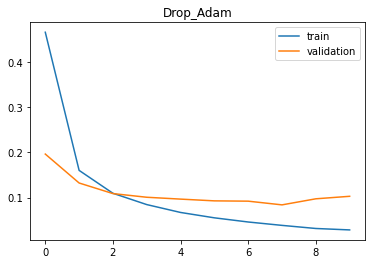

Train accuracy: 0.9902666666666666
Train precision: 0.9903129849407307
Train recall: 0.990063346936086
Train f1: 0.9901128615617034
Test accuracy: 0.9724
Test precision: 0.9725339574946771
Test recall: 0.971808068496304
Test f1: 0.972021044205609


In [ ]:
model_drop_adam=MLP_dropout(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_Adam(model_drop_adam)
criterion=nn.CrossEntropyLoss().to(device)
model_drop_adam,_,_=train_optim(trainloader_minibatch,testloader,model_drop_adam,optimiser,criterion,"Drop_Adam")



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:23,  6.52it/s]

  1%|          | 6/938 [00:00<00:34, 27.07it/s]

  1%|▏         | 12/938 [00:00<00:22, 40.28it/s]

  2%|▏         | 19/938 [00:00<00:19, 46.32it/s]

  3%|▎         | 25/938 [00:00<00:19, 45.95it/s]

  3%|▎         | 32/938 [00:00<00:17, 51.89it/s]

  4%|▍         | 38/938 [00:00<00:18, 49.89it/s]

  5%|▍         | 45/938 [00:00<00:17, 51.46it/s]

  5%|▌         | 51/938 [00:01<00:16, 53.52it/s]

  6%|▌         | 57/938 [00:01<00:15, 55.23it/s]

  7%|▋         | 63/938 [00:01<00:15, 55.98it/s]

  7%|▋         | 69/938 [00:01<00:15, 54.87it/s]

  8%|▊         | 75/938 [00:01<00:16, 51.75it/s]

  9%|▊         | 81/938 [00:01<00:16, 52.27it/s]

  9%|▉         | 87/938 [00:01<00:16, 52.93it/s]

 10%|▉         | 93/938 [00:01<00:16, 52.44it/s]

 11%|█         | 99/938 [00:01<00:16, 51.41it/s]

 11%|█         | 105/938 [00:02<00:15, 52.74it/s]

 12%|█▏        | 111/938 [00:02<00:15, 52.41it/s]

 12%|█▏

Epoch: 1, Train Loss: 0.3809, Test Loss: 0.1397




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<03:00,  5.20it/s]

  1%|          | 8/938 [00:00<00:29, 31.58it/s]

  2%|▏         | 15/938 [00:00<00:21, 43.92it/s]

  2%|▏         | 21/938 [00:00<00:20, 45.52it/s]

  3%|▎         | 26/938 [00:00<00:20, 44.98it/s]

  3%|▎         | 32/938 [00:00<00:19, 47.22it/s]

  4%|▍         | 38/938 [00:00<00:18, 49.95it/s]

  5%|▍         | 44/938 [00:00<00:17, 52.19it/s]

  5%|▌         | 50/938 [00:01<00:17, 50.35it/s]

  6%|▌         | 57/938 [00:01<00:16, 53.06it/s]

  7%|▋         | 64/938 [00:01<00:15, 57.23it/s]

  8%|▊         | 71/938 [00:01<00:14, 58.34it/s]

  8%|▊         | 77/938 [00:01<00:15, 57.23it/s]

  9%|▉         | 83/938 [00:01<00:15, 56.59it/s]

  9%|▉         | 89/938 [00:01<00:15, 55.66it/s]

 10%|█         | 95/938 [00:01<00:15, 54.03it/s]

 11%|█         | 101/938 [00:02<00:15, 52.43it/s]

 11%|█▏        | 107/938 [00:02<00:16, 49.45it/s]

 12%|█▏        | 113/938 [00:02<00:15, 52.12it/s]

 13%|█

Epoch: 2, Train Loss: 0.1160, Test Loss: 0.1069




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:59,  5.22it/s]

  1%|          | 8/938 [00:00<00:29, 31.23it/s]

  1%|▏         | 14/938 [00:00<00:22, 41.13it/s]

  2%|▏         | 20/938 [00:00<00:20, 44.99it/s]

  3%|▎         | 26/938 [00:00<00:18, 48.68it/s]

  3%|▎         | 32/938 [00:00<00:19, 46.16it/s]

  4%|▍         | 40/938 [00:00<00:17, 52.62it/s]

  5%|▍         | 46/938 [00:01<00:17, 50.02it/s]

  6%|▌         | 53/938 [00:01<00:16, 54.80it/s]

  7%|▋         | 61/938 [00:01<00:14, 59.53it/s]

  7%|▋         | 68/938 [00:01<00:15, 57.76it/s]

  8%|▊         | 74/938 [00:01<00:15, 57.28it/s]

  9%|▊         | 82/938 [00:01<00:14, 59.81it/s]

  9%|▉         | 89/938 [00:01<00:14, 60.22it/s]

 10%|█         | 96/938 [00:01<00:14, 57.06it/s]

 11%|█         | 102/938 [00:01<00:15, 54.28it/s]

 12%|█▏        | 109/938 [00:02<00:14, 57.25it/s]

 12%|█▏        | 115/938 [00:02<00:14, 55.22it/s]

 13%|█▎        | 121/938 [00:02<00:14, 54.47it/s]

 14%|

Epoch: 3, Train Loss: 0.0769, Test Loss: 0.0947




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:58,  5.26it/s]

  1%|          | 7/938 [00:00<00:32, 28.64it/s]

  1%|▏         | 14/938 [00:00<00:21, 42.94it/s]

  2%|▏         | 21/938 [00:00<00:17, 51.33it/s]

  3%|▎         | 27/938 [00:00<00:17, 52.48it/s]

  4%|▎         | 33/938 [00:00<00:16, 54.48it/s]

  4%|▍         | 39/938 [00:00<00:18, 49.24it/s]

  5%|▌         | 47/938 [00:00<00:15, 55.97it/s]

  6%|▌         | 53/938 [00:01<00:16, 54.96it/s]

  6%|▋         | 59/938 [00:01<00:17, 50.75it/s]

  7%|▋         | 67/938 [00:01<00:15, 56.29it/s]

  8%|▊         | 73/938 [00:01<00:15, 56.09it/s]

  9%|▊         | 81/938 [00:01<00:14, 59.27it/s]

  9%|▉         | 87/938 [00:01<00:14, 59.10it/s]

 10%|█         | 96/938 [00:01<00:12, 66.38it/s]

 11%|█▏        | 106/938 [00:01<00:11, 74.42it/s]

 12%|█▏        | 115/938 [00:02<00:10, 75.96it/s]

 13%|█▎        | 124/938 [00:02<00:10, 79.53it/s]

 14%|█▍        | 133/938 [00:02<00:10, 79.87it/s]

 15%|

Epoch: 4, Train Loss: 0.0593, Test Loss: 0.0916




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:45,  5.65it/s]

  1%|          | 8/938 [00:00<00:27, 34.23it/s]

  1%|▏         | 14/938 [00:00<00:22, 41.84it/s]

  2%|▏         | 20/938 [00:00<00:20, 45.81it/s]

  3%|▎         | 25/938 [00:00<00:19, 46.74it/s]

  3%|▎         | 31/938 [00:00<00:18, 47.75it/s]

  4%|▍         | 37/938 [00:00<00:18, 49.68it/s]

  5%|▍         | 45/938 [00:00<00:15, 56.81it/s]

  6%|▌         | 55/938 [00:01<00:12, 68.37it/s]

  7%|▋         | 64/938 [00:01<00:11, 73.94it/s]

  8%|▊         | 72/938 [00:01<00:11, 74.93it/s]

  9%|▊         | 81/938 [00:01<00:11, 77.21it/s]

 10%|▉         | 90/938 [00:01<00:10, 80.44it/s]

 11%|█         | 100/938 [00:01<00:10, 83.66it/s]

 12%|█▏        | 109/938 [00:01<00:10, 81.29it/s]

 13%|█▎        | 119/938 [00:01<00:09, 85.39it/s]

 14%|█▎        | 128/938 [00:01<00:09, 85.16it/s]

 15%|█▍        | 137/938 [00:02<00:09, 82.28it/s]

 16%|█▌        | 146/938 [00:02<00:09, 83.90it/s]

 17

Epoch: 5, Train Loss: 0.0508, Test Loss: 0.0808




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:44,  5.68it/s]

  1%|          | 6/938 [00:00<00:36, 25.34it/s]

  1%|▏         | 13/938 [00:00<00:21, 42.22it/s]

  2%|▏         | 22/938 [00:00<00:16, 56.79it/s]

  3%|▎         | 31/938 [00:00<00:13, 66.12it/s]

  4%|▍         | 40/938 [00:00<00:12, 72.14it/s]

  5%|▌         | 49/938 [00:00<00:11, 76.72it/s]

  6%|▌         | 57/938 [00:00<00:11, 76.36it/s]

  7%|▋         | 66/938 [00:01<00:11, 78.82it/s]

  8%|▊         | 74/938 [00:01<00:11, 77.25it/s]

  9%|▉         | 84/938 [00:01<00:10, 80.16it/s]

 10%|█         | 94/938 [00:01<00:10, 84.10it/s]

 11%|█         | 104/938 [00:01<00:09, 85.76it/s]

 12%|█▏        | 113/938 [00:01<00:09, 85.06it/s]

 13%|█▎        | 122/938 [00:01<00:09, 83.65it/s]

 14%|█▍        | 132/938 [00:01<00:09, 85.63it/s]

 15%|█▌        | 141/938 [00:01<00:09, 85.41it/s]

 16%|█▌        | 150/938 [00:02<00:09, 85.94it/s]

 17%|█▋        | 159/938 [00:02<00:09, 86.35it/s]

 1

Epoch: 6, Train Loss: 0.0408, Test Loss: 0.0785




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:50,  8.47it/s]

  1%|          | 9/938 [00:00<00:19, 46.76it/s]

  2%|▏         | 19/938 [00:00<00:13, 67.83it/s]

  3%|▎         | 28/938 [00:00<00:12, 73.86it/s]

  4%|▍         | 36/938 [00:00<00:12, 73.94it/s]

  5%|▍         | 46/938 [00:00<00:11, 77.82it/s]

  6%|▌         | 56/938 [00:00<00:10, 80.66it/s]

  7%|▋         | 65/938 [00:00<00:11, 78.18it/s]

  8%|▊         | 73/938 [00:01<00:11, 77.45it/s]

  9%|▉         | 83/938 [00:01<00:10, 82.47it/s]

 10%|▉         | 92/938 [00:01<00:10, 81.81it/s]

 11%|█         | 102/938 [00:01<00:09, 84.96it/s]

 12%|█▏        | 112/938 [00:01<00:09, 86.08it/s]

 13%|█▎        | 121/938 [00:01<00:09, 86.90it/s]

 14%|█▍        | 131/938 [00:01<00:09, 88.39it/s]

 15%|█▍        | 140/938 [00:01<00:09, 80.81it/s]

 16%|█▌        | 149/938 [00:01<00:09, 79.18it/s]

 17%|█▋        | 158/938 [00:02<00:09, 80.54it/s]

 18%|█▊        | 167/938 [00:02<00:09, 80.44it/s]

 

Epoch: 7, Train Loss: 0.0350, Test Loss: 0.1007




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:59,  7.87it/s]

  1%|          | 10/938 [00:00<00:18, 50.86it/s]

  2%|▏         | 20/938 [00:00<00:13, 68.95it/s]

  3%|▎         | 29/938 [00:00<00:12, 73.51it/s]

  4%|▍         | 38/938 [00:00<00:11, 78.32it/s]

  5%|▍         | 46/938 [00:00<00:11, 76.76it/s]

  6%|▌         | 55/938 [00:00<00:11, 78.21it/s]

  7%|▋         | 65/938 [00:00<00:10, 82.98it/s]

  8%|▊         | 74/938 [00:00<00:10, 82.66it/s]

  9%|▉         | 83/938 [00:01<00:10, 79.96it/s]

 10%|▉         | 92/938 [00:01<00:10, 80.00it/s]

 11%|█         | 101/938 [00:01<00:10, 81.72it/s]

 12%|█▏        | 110/938 [00:01<00:10, 81.31it/s]

 13%|█▎        | 119/938 [00:01<00:09, 82.16it/s]

 14%|█▎        | 128/938 [00:01<00:09, 82.81it/s]

 15%|█▍        | 137/938 [00:01<00:09, 84.79it/s]

 16%|█▌        | 146/938 [00:01<00:09, 83.72it/s]

 17%|█▋        | 155/938 [00:01<00:09, 84.21it/s]

 17%|█▋        | 164/938 [00:02<00:09, 81.37it/s]



Epoch: 8, Train Loss: 0.0315, Test Loss: 0.0877




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:44,  8.99it/s]

  1%|          | 8/938 [00:00<00:21, 43.27it/s]

  2%|▏         | 18/938 [00:00<00:13, 65.73it/s]

  3%|▎         | 26/938 [00:00<00:12, 70.54it/s]

  4%|▎         | 34/938 [00:00<00:12, 73.33it/s]

  4%|▍         | 42/938 [00:00<00:12, 73.05it/s]

  6%|▌         | 52/938 [00:00<00:11, 77.79it/s]

  6%|▋         | 60/938 [00:00<00:11, 78.04it/s]

  7%|▋         | 69/938 [00:00<00:11, 76.41it/s]

  8%|▊         | 78/938 [00:01<00:10, 79.56it/s]

  9%|▉         | 86/938 [00:01<00:10, 79.32it/s]

 10%|█         | 95/938 [00:01<00:10, 80.81it/s]

 11%|█         | 104/938 [00:01<00:10, 82.51it/s]

 12%|█▏        | 113/938 [00:01<00:09, 83.96it/s]

 13%|█▎        | 122/938 [00:01<00:09, 85.60it/s]

 14%|█▍        | 131/938 [00:01<00:09, 84.30it/s]

 15%|█▍        | 140/938 [00:01<00:09, 82.82it/s]

 16%|█▌        | 149/938 [00:01<00:09, 83.73it/s]

 17%|█▋        | 158/938 [00:02<00:09, 81.55it/s]

 1

Epoch: 9, Train Loss: 0.0278, Test Loss: 0.1001




  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:57,  7.97it/s]

  1%|          | 10/938 [00:00<00:18, 51.53it/s]

  2%|▏         | 19/938 [00:00<00:14, 64.54it/s]

  3%|▎         | 28/938 [00:00<00:12, 73.78it/s]

  4%|▍         | 36/938 [00:00<00:12, 74.18it/s]

  5%|▍         | 46/938 [00:00<00:11, 79.74it/s]

  6%|▌         | 55/938 [00:00<00:10, 82.42it/s]

  7%|▋         | 64/938 [00:00<00:10, 80.02it/s]

  8%|▊         | 73/938 [00:00<00:10, 80.04it/s]

  9%|▊         | 82/938 [00:01<00:10, 81.98it/s]

 10%|▉         | 92/938 [00:01<00:09, 85.44it/s]

 11%|█         | 101/938 [00:01<00:10, 82.30it/s]

 12%|█▏        | 111/938 [00:01<00:09, 84.97it/s]

 13%|█▎        | 120/938 [00:01<00:09, 84.44it/s]

 14%|█▍        | 129/938 [00:01<00:09, 84.34it/s]

 15%|█▍        | 138/938 [00:01<00:09, 83.48it/s]

 16%|█▌        | 147/938 [00:01<00:09, 84.90it/s]

 17%|█▋        | 156/938 [00:01<00:09, 86.02it/s]

 18%|█▊        | 165/938 [00:02<00:09, 80.98it/s]



Epoch: 10, Train Loss: 0.0230, Test Loss: 0.1002


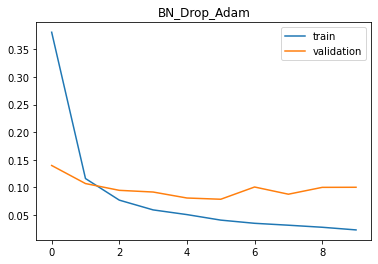

Train accuracy: 0.9895
Train precision: 0.9894332780815667
Train recall: 0.9893867588295093
Train f1: 0.9893507891472779
Test accuracy: 0.9723
Test precision: 0.9724162555173382
Test recall: 0.9721417849997722
Test f1: 0.9721386845587301


In [ ]:

model_drop_bn_adam=MLP_dropout_batchnorm(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_Adam(model_drop_bn_adam)
criterion=nn.CrossEntropyLoss().to(device)
model_drop_bn_adam,_,_=train_optim(trainloader_minibatch,testloader,model_drop_bn_adam,optimiser,criterion,"BN_Drop_Adam")

### Analysis

#### SimpleMLP
with adam optimiser
Train accuracy: 0.9902666666666666

Train precision: 0.9901866449190564

Train recall: 0.9902753047051484

Train f1: 0.9902192432942428

Test accuracy: 0.9723

Test precision: 0.9729959046319241

Test recall: 0.9729985702041375

Test f1: 0.9729733372142404

#### BN

Train accuracy: 0.9929666666666667

Train precision: 0.9929779469820208

Train recall: 0.9928675366653799

Train f1: 0.9928921793762792

Test accuracy: 0.9752

Test precision: 0.9754701020441734

Test recall: 0.9748148807527924

Test f1: 0.975043533188073

#### Dropout


Train accuracy: 0.9902666666666666

Train precision: 0.9903129849407307

Train recall: 0.990063346936086

Train f1: 0.9901128615617034

Test accuracy: 0.9724

Test precision: 0.9725339574946771

Test recall: 0.971808068496304

Test f1: 0.972021044205609

#### BN + Dropout


Train accuracy: 0.9895

Train precision: 0.9894332780815667

Train recall: 0.9893867588295093

Train f1: 0.9893507891472779

Test accuracy: 0.9723

Test precision: 0.9724162555173382

Test recall: 0.9721417849997722

Test f1: 0.9721386845587301

Training becomes more stable thanks to Batchnorm, which lessens the dependence of gradients on the scale of the parameters. Batch normalisation also slightly regularises the data by lowering the internal covariate shift. Regularization lessens overfitting and increases the model's capacity for generalisation.

During each training iteration, a certain percentage of the neurons in a layer are randomly dropped out (set to zero) using the dropout regularisation technique. As a result, the network is compelled to learn redundant representations, which improves its ability to generalise to new data. Dropout also encourages the network to learn more robust features by preventing co-adaptation of neurons.

However, we observe that the accuracy only remains the same as we adopt BN and Dropout. This is might be because the model is not overfitting much. Also, the model is not very deep, so the effect of BN and Dropout is not very significant.

### Step eight: Mini-batch vs Stocastic
Now that you might have a clear winner in your mind regarding which model and settings perform the best, train it on mini-batch and stocastic and compare time taken, loss curve, accuracy etc.

Perform an analysis like never before!


100%|██████████| 60000/60000 [03:32<00:00, 282.78it/s]


Epoch: 1, Train Loss: 0.2307, Test Loss: 0.1564



100%|██████████| 60000/60000 [03:37<00:00, 275.31it/s]


Epoch: 2, Train Loss: 0.1377, Test Loss: 0.1364



100%|██████████| 60000/60000 [03:40<00:00, 271.67it/s]


Epoch: 3, Train Loss: 0.1176, Test Loss: 0.1594



100%|██████████| 60000/60000 [03:47<00:00, 263.68it/s]


Epoch: 4, Train Loss: 0.1023, Test Loss: 0.1944



100%|██████████| 60000/60000 [03:49<00:00, 261.38it/s]


Epoch: 5, Train Loss: 0.0984, Test Loss: 0.1467



100%|██████████| 60000/60000 [03:52<00:00, 258.32it/s]


Epoch: 6, Train Loss: 0.0871, Test Loss: 0.1882



100%|██████████| 60000/60000 [03:51<00:00, 259.03it/s]


Epoch: 7, Train Loss: 0.0814, Test Loss: 0.2010



100%|██████████| 60000/60000 [03:56<00:00, 253.52it/s]


Epoch: 8, Train Loss: 0.0724, Test Loss: 0.1829



100%|██████████| 60000/60000 [03:54<00:00, 255.37it/s]


Epoch: 9, Train Loss: 0.0725, Test Loss: 0.2013



100%|██████████| 60000/60000 [03:54<00:00, 255.81it/s]

Epoch: 10, Train Loss: 0.0676, Test Loss: 0.2156


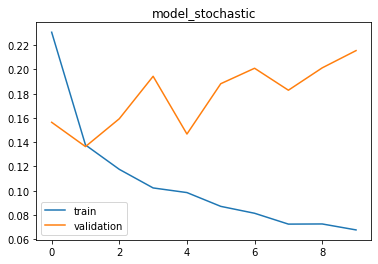

Train accuracy: 0.9867833333333333
Train precision: 0.9867589248877356
Train recall: 0.9868079740026253
Train f1: 0.9867393139585874
Test accuracy: 0.9676
Test precision: 0.9674085306812341
Test recall: 0.9674427978420784
Test f1: 0.9672675750525246


In [10]:
model_stochastic=SimpleMLP(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
optimiser=optim_Adam(model_stochastic)
criterion=nn.CrossEntropyLoss().to(device)
model_stochastic,_,_=train_optim(trainloader_stochastic,testloader,model_stochastic,optimiser,criterion,"model_stochastic")

### Analysis

#### Mini-batch
Train accuracy: 0.9902666666666666
Train precision: 0.9901866449190564
Train recall: 0.9902753047051484
Train f1: 0.9902192432942428
Test accuracy: 0.9732
Test precision: 0.9729959046319241
Test recall: 0.9729985702041375
Test f1: 0.9729733372142404
Train Time: 2m

#### Stocastic

Train accuracy: 0.9867833333333333
Train precision: 0.9867589248877356
Train recall: 0.9868079740026253
Train f1: 0.9867393139585874
Test accuracy: 0.9676
Test precision: 0.9674085306812341
Test recall: 0.9674427978420784
Test f1: 0.9672675750525246
Train Time: 20m

We can see from the loss curves that using trainloader stocastic results in a rise in the validation loss. This is a result of the model's poor data generalisation. This is due to the model's inability to recognise underlying patterns in the data because it is trained on a single case at a time (and we are only running for 10 epochs). As a result, the model cannot adequately generalise to the data.
As a result, mini-batch has somewhat higher accuracy than stocastic.

Moreover, stochastic training takes substantially longer than mini-batch training. This is so because in stochastic learning, the weights are updated after each data point, whereas in batch learning, they are modified after processing the entire batch. As a result, batch learning typically requires fewer iterations than stochastic learning, which shortens the training period overall.

### And most importantly!!! What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations.

In [ ]:
# text here